# Run Datasets

## MacLaren
```
submit_subjects \
  --upload_metadata \
  --save_details \
  --stagger \
  -q reTHINQ-c5-spot \
  -t 1.0.0-rc.11 \
  -I s3://cmet-scratch/maclaren-cmeds/ \
  -o s3://cmet-scratch/20200609-mclaren-1.0.0-rc.11-42-g8d976b0--take4/
```

## DefNef
```
submit_subjects \
  --upload_metadata \
  --save_details \
  --stagger \
  -q reTHINQ-c5-spot \
  -t 1.0.0-rc.11 \
  -I s3://cmet-testsets/DecNefTS/ \
  -o s3://cmet-scratch/20200615-DecNefTS-1.0.0-rc.11/
```

In [7]:
import json
import os
import fnmatch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Helper functions

def find_json_files(filepath, pattern="*.json"):
    """
    Given:
    - a directory to search

    Produce:
    - a list of all .json files anywhere in the directory path
    - equivalient to the shell command `find /filepath -name '*.json'`
    """
    filelist = []
    for dName, sdName, fList in os.walk(filepath):
        for fileName in fList:
            if fnmatch.fnmatch(fileName, pattern):
                filelist.append(os.path.join(dName, fileName))
    return filelist

def load_json_file(filename):
    """
    Given:
    - a json file

    Produce:
    - dictionary
    """
    with open(filename) as infile:
        json_data = json.load(infile)
    return json_data

def load_dataset(jsonpath, demofile, drop_subjects=None):
    json_files = find_json_files(jsonpath)
    subject_data = {}
    vol_data = {}
    norm_data = {}
    subject_list = []
    for file in json_files:
        subname = os.path.basename(os.path.dirname(file))
        subject_data[subname] = load_json_file(file)
        if 'normative' in subject_data[subname] and 'volume' in subject_data[subname]['normative']:
            # Subject was processed without error
            vol_data[subname] = subject_data[subname]['measurements']['volume']
            norm_data[subname] = {}
            for vol in subject_data[subname]['normative']['volume']:
                norm_data[subname][vol] = subject_data[subname]['normative']['volume'][vol]['percentiles']['percentile']        
            subject_list.append(subname)
        else:
            # Subject was processed without error
            print('Ignoring Subject (did it error out?)', subname)

    demo_dataf = pd.read_csv(demofile, sep='\t', index_col='subject_id')
    # for convience, concatenate demographics info onto norm and data dataframes
    vol_temp_df = pd.DataFrame.from_dict(data=vol_data, orient='index')
    norm_temp_df = pd.DataFrame.from_dict(data=norm_data, orient='index')
    if drop_subjects is not None:
        print('Dropping the following subejcts:', drop_subjects)
        demo_dataf.drop(drop_subjects, errors='ignore')
        vol_temp_df.drop(drop_subjects, errors='ignore')
        norm_temp_df.drop(drop_subjects, errors='ignore')
    vol_dataf = pd.concat([demo_dataf,vol_temp_df],axis=1)
    norm_dataf = pd.concat([demo_dataf,norm_temp_df],axis=1)

    return vol_dataf, norm_dataf

# Copy Data Locally

## Maclaren
```
mkdir -p /home/paul/cmet/data/20200609-mclaren-1.0.0-rc.11-42-g8d976b0--take4
cd /home/paul/cmet/data/20200609-mclaren-1.0.0-rc.11-42-g8d976b0--take4
aws s3 cp s3://cmet-scratch/maclaren-cmeds/demographics.tsv .
aws s3 cp \
  --recursive \
  --exclude "*" \
  --include "*subject_info.json" \
  --include "*.pdf" \
  s3://cmet-scratch/20200609-mclaren-1.0.0-rc.11-42-g8d976b0--take4/maclaren-cmeds/ .
find . -type d -name 'cache' -exec rm -rf {} \;
```

## DecNef
```
mkdir -p /home/paul/cmet/data/20200615-DecNefTS-1.0.0-rc.11
cd /home/paul/cmet/data/20200615-DecNefTS-1.0.0-rc.11
aws s3 cp s3://cmet-testsets/DecNefTS/demographics.tsv .
aws s3 cp \
  --recursive \
  --exclude "*" \
  --include "*subject_info.json" \
  --include "*.pdf" \
  --include "*.log" \
  s3://cmet-scratch/20200615-DecNefTS-1.0.0-rc.11/DecNefTS/ .
rm -f ./sub-058/cache/59d231cda1504d2d/rethinq/subject_info.json
```

In [9]:
# Local DecNef Vars
decnef_dir = '/home/paul/cmet/data/20200615-DecNefTS-1.0.0-rc.11/'
decnef_tsv = '/home/paul/cmet/data/20200615-DecNefTS-1.0.0-rc.11/demographics.tsv'
# Local MacLaren Vars
maclaren_dir = '/home/paul/cmet/data/20200609-mclaren-1.0.0-rc.11-42-g8d976b0--take4/'
maclaren_tsv = '/home/paul/cmet/data/20200609-mclaren-1.0.0-rc.11-42-g8d976b0--take4/demographics.tsv'

In [10]:
# Load DecNef data into dataframes
decnef_vol_df, decnef_norm_df = load_dataset(decnef_dir, decnef_tsv, drop_subjects=['sub-143'])

Ignoring Subject (did it error out?) sub-058
Dropping the following subejcts: ['sub-143']


In [11]:
# Load MacLaren data into dataframes
maclaren_vol_df, maclaren_norm_df = load_dataset(maclaren_dir, maclaren_tsv)

Ignoring Subject (did it error out?) sub-01_run-39
Ignoring Subject (did it error out?) sub-01_run-02
Ignoring Subject (did it error out?) sub-01_run-09
Ignoring Subject (did it error out?) sub-01_run-08
Ignoring Subject (did it error out?) sub-01_run-24
Ignoring Subject (did it error out?) sub-01_run-33
Ignoring Subject (did it error out?) sub-01_run-13
Ignoring Subject (did it error out?) sub-01_run-16
Ignoring Subject (did it error out?) sub-01_run-14
Ignoring Subject (did it error out?) sub-01_run-32
Ignoring Subject (did it error out?) sub-01_run-01
Ignoring Subject (did it error out?) sub-01_run-36
Ignoring Subject (did it error out?) sub-01_run-06
Ignoring Subject (did it error out?) sub-01_run-26
Ignoring Subject (did it error out?) sub-01_run-27
Ignoring Subject (did it error out?) sub-01_run-40
Ignoring Subject (did it error out?) sub-01_run-03
Ignoring Subject (did it error out?) sub-01_run-19
Ignoring Subject (did it error out?) sub-01_run-18
Ignoring Subject (did it error 

In [13]:
structs_of_interest = [
    'Left-Amygdala',
    'Left-Caudate',
    'Left-Hippocampus',
    'Left-Lateral-Ventricle',
    'Left-Putamen',
    'Left-Thalamus']

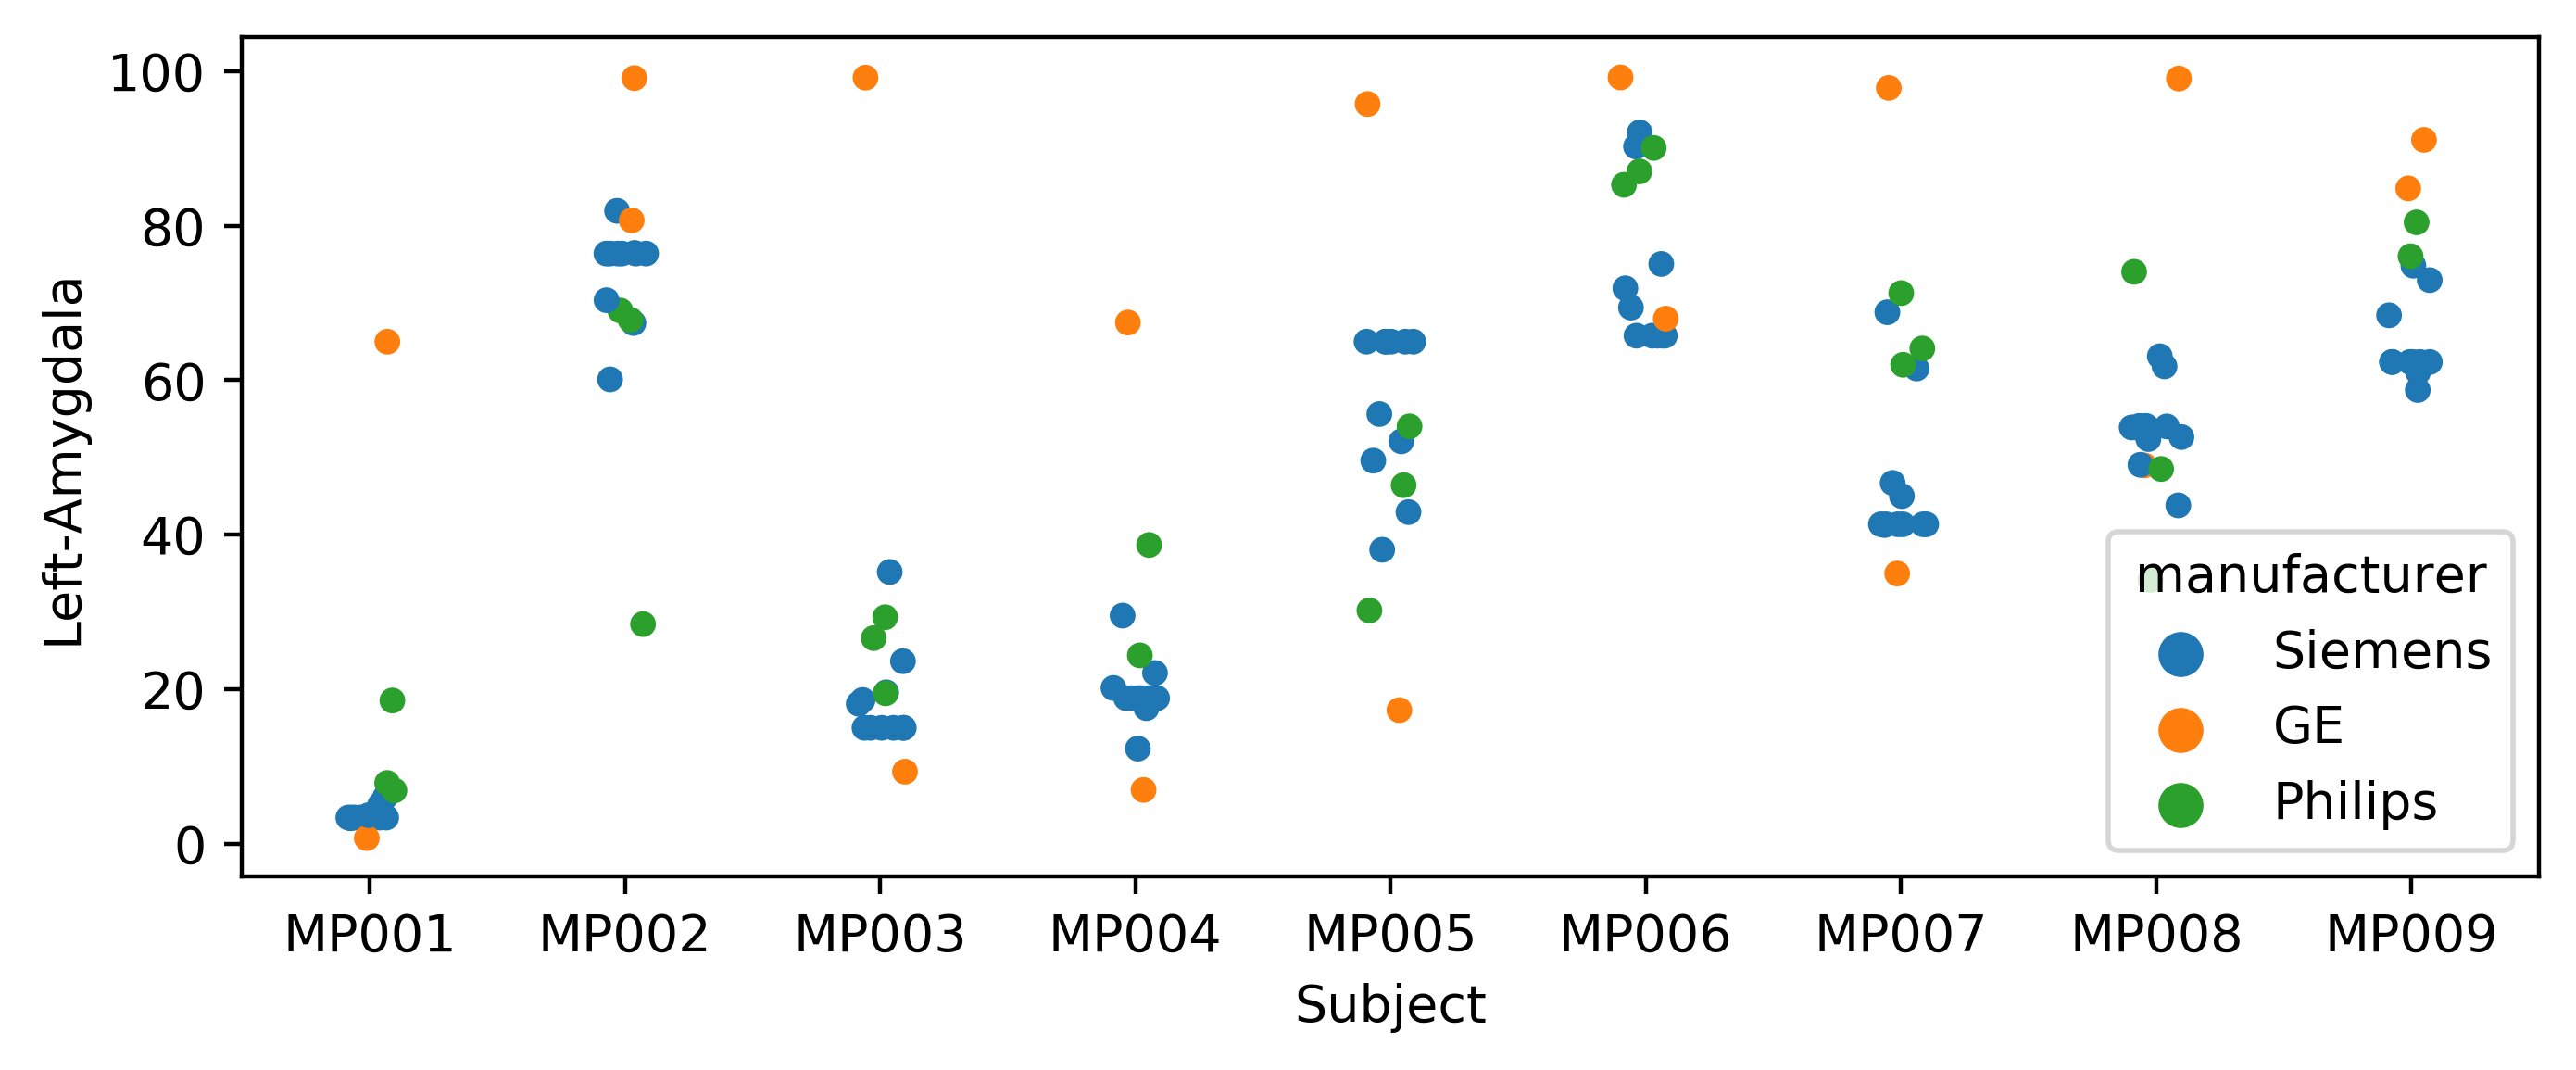

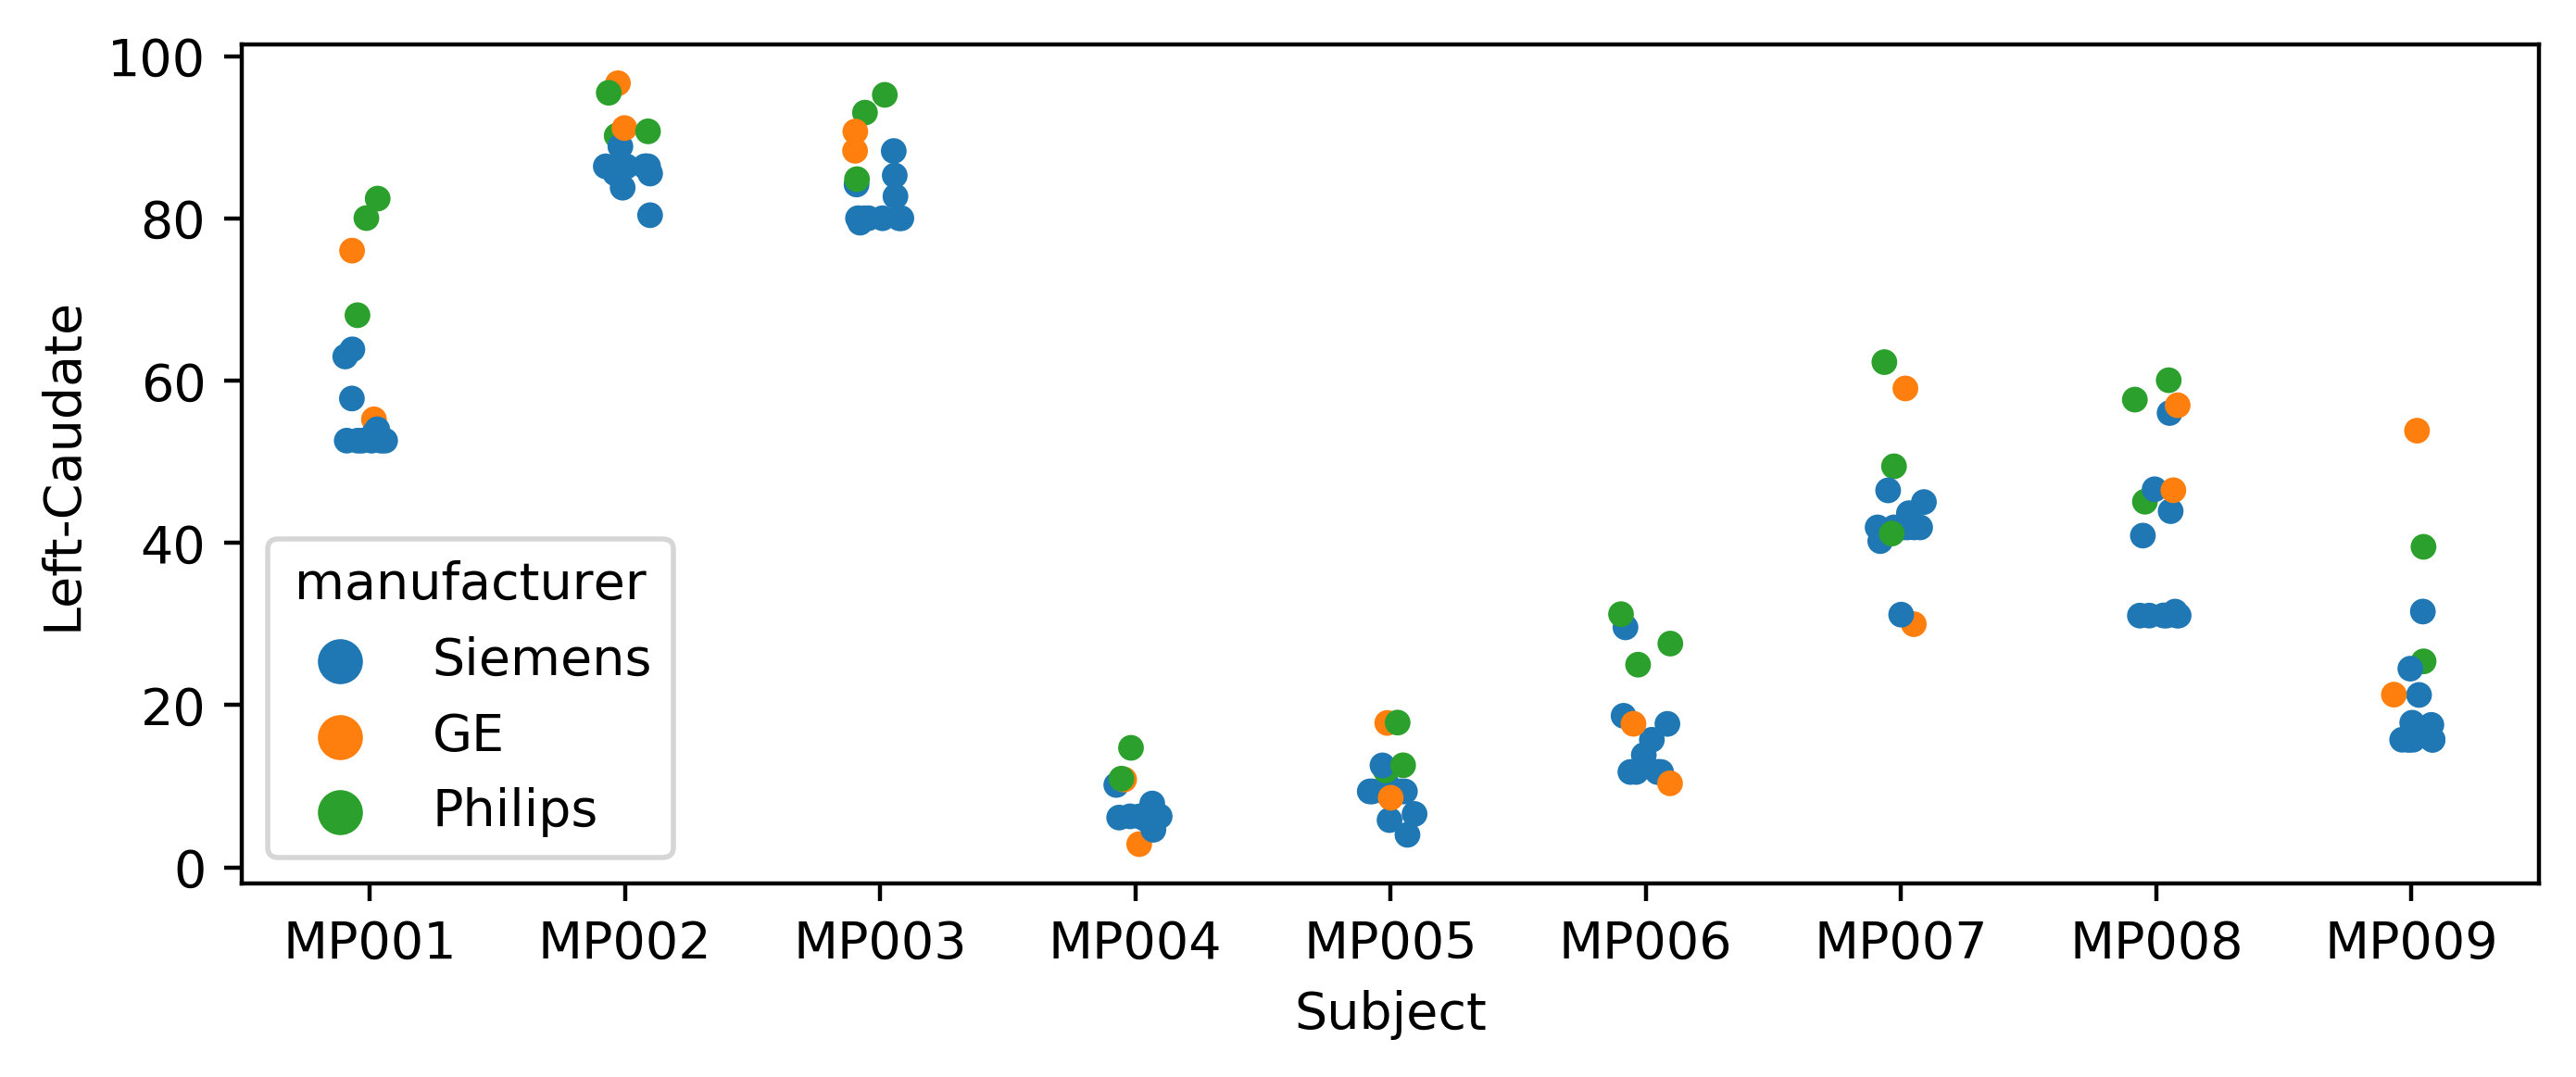

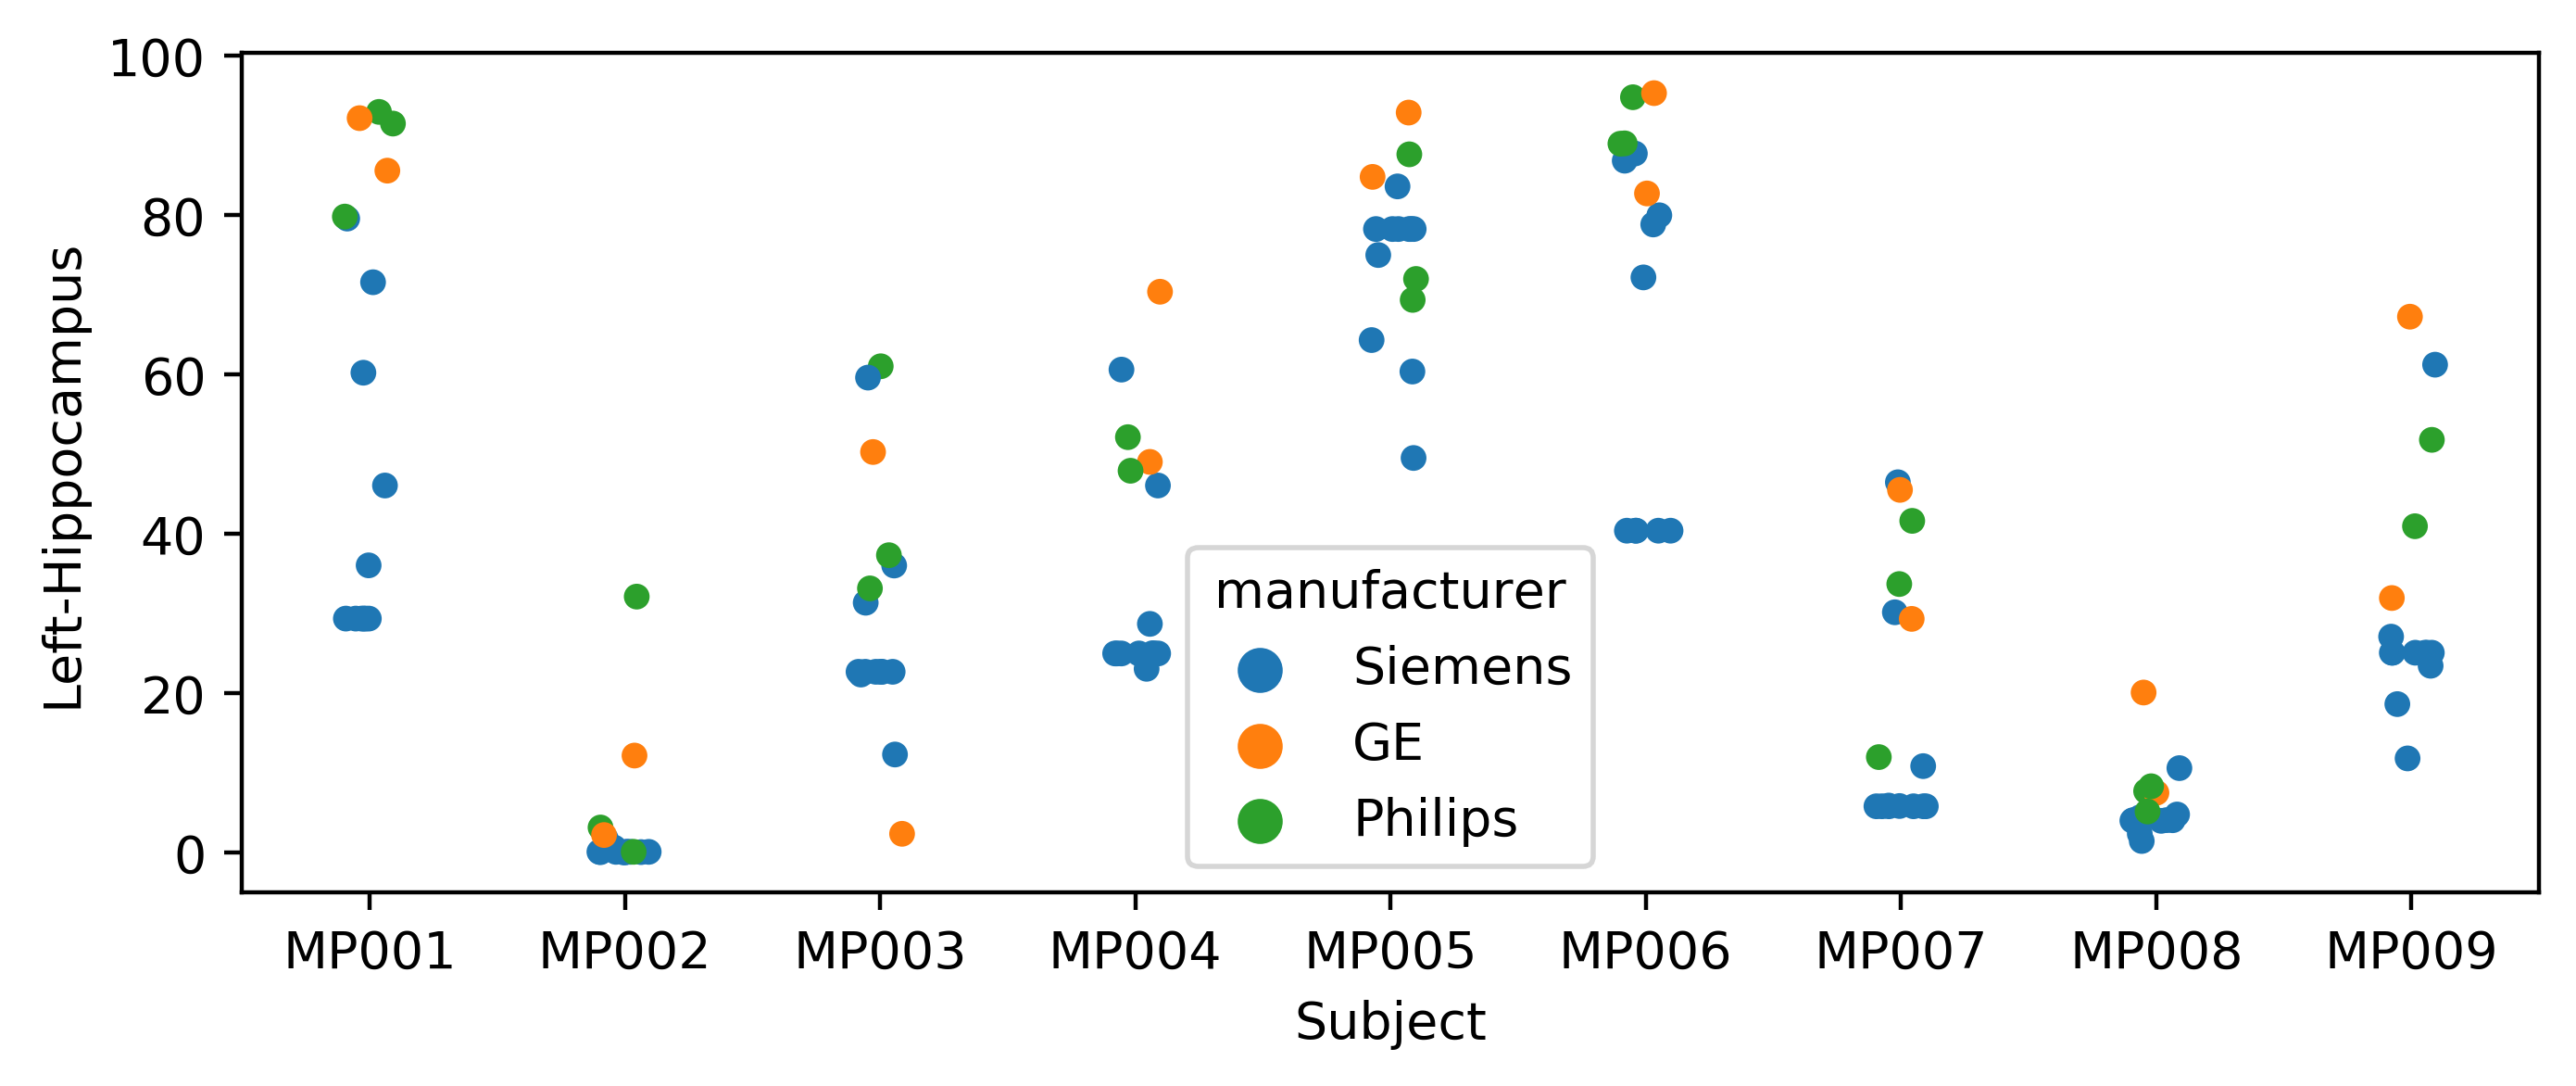

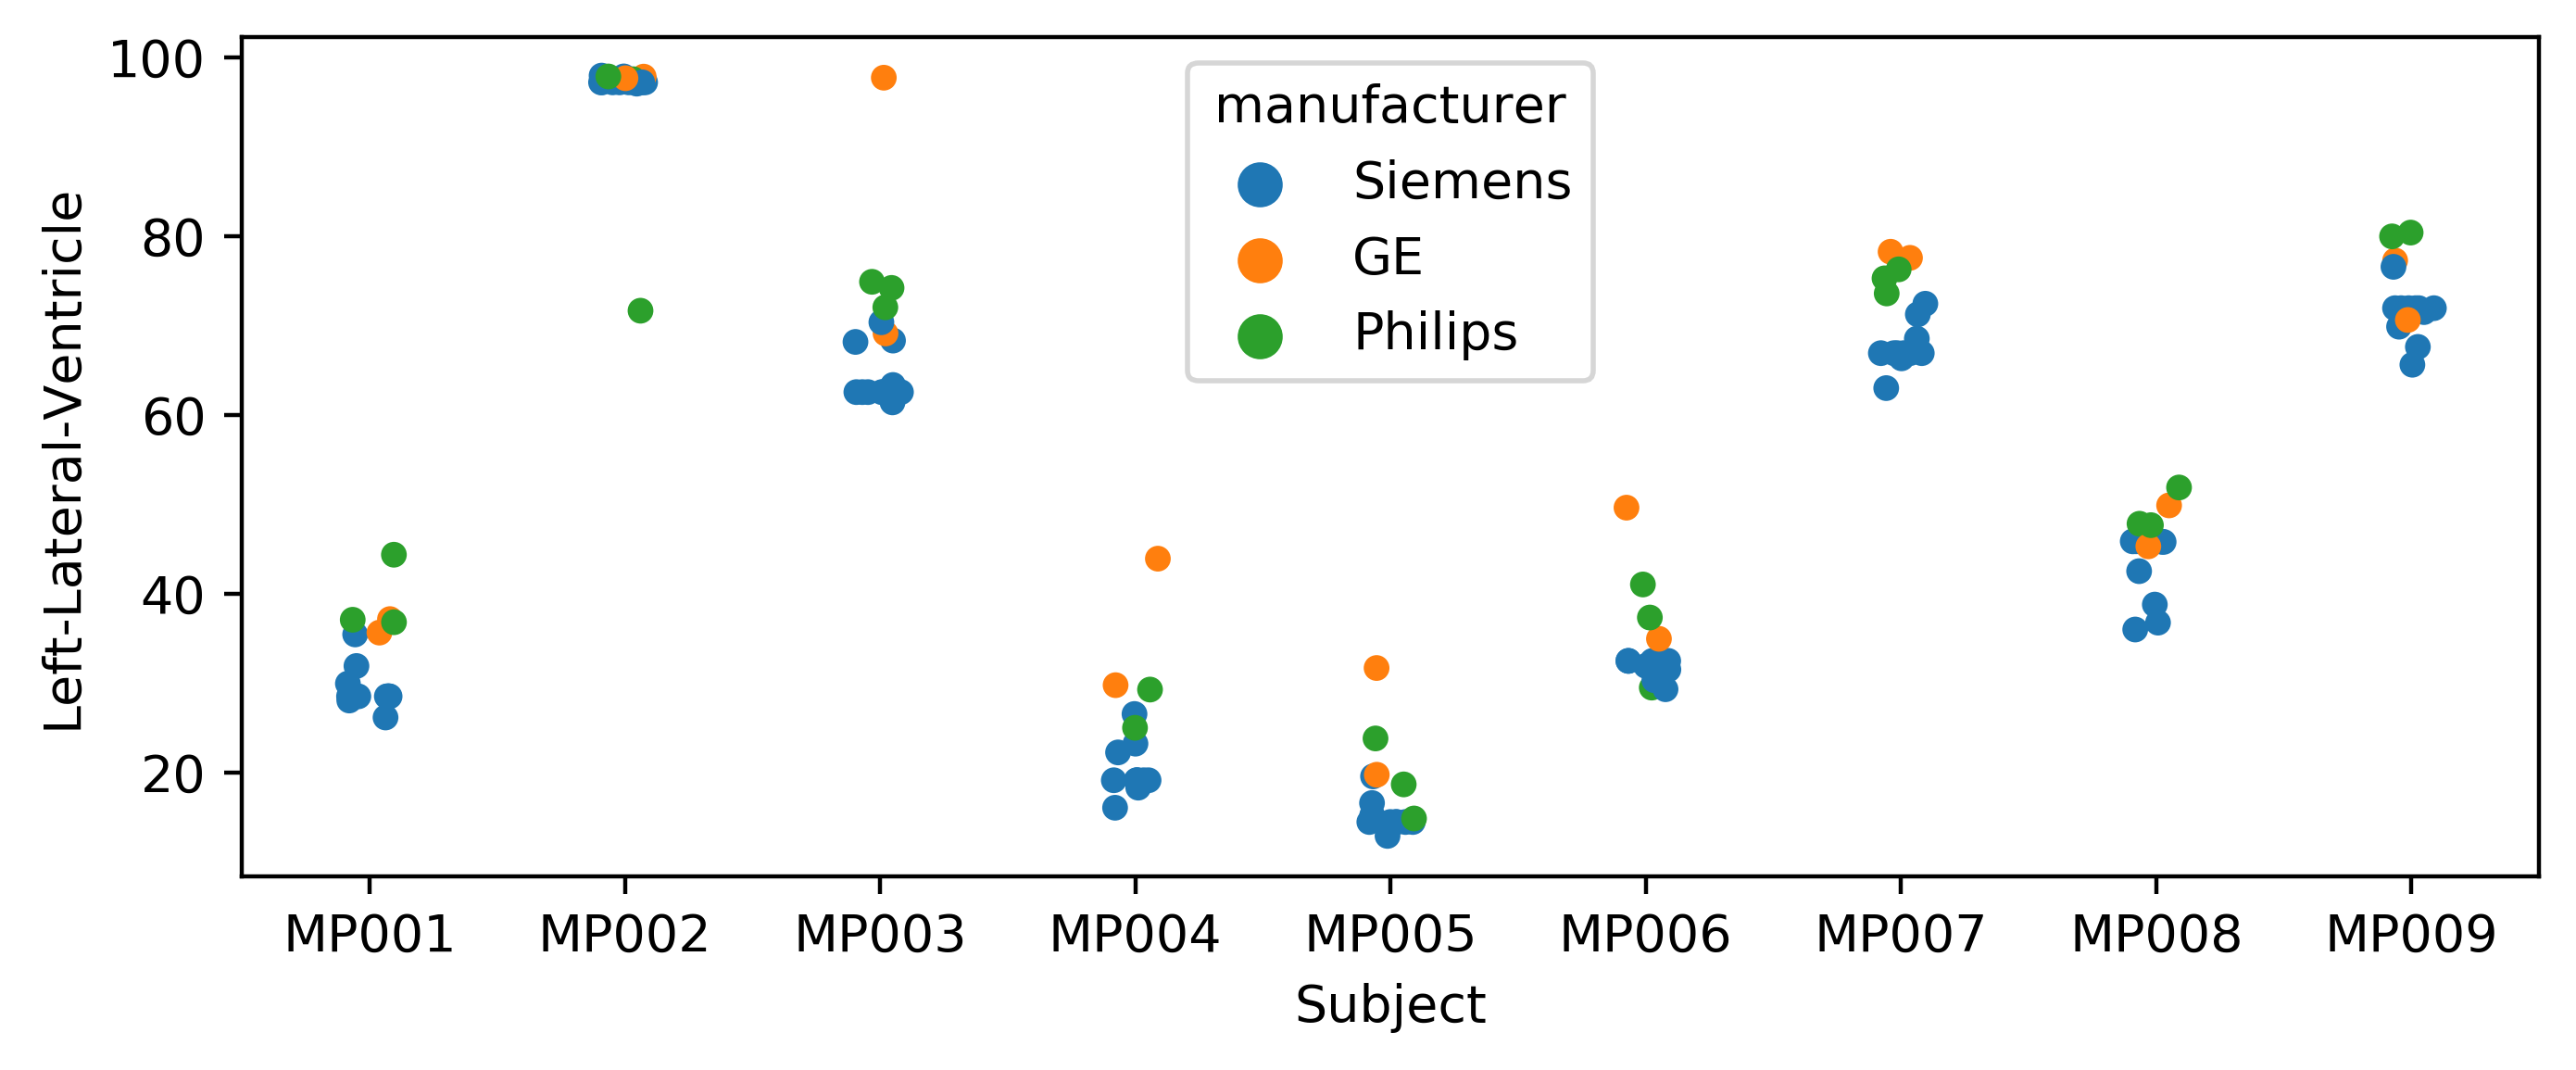

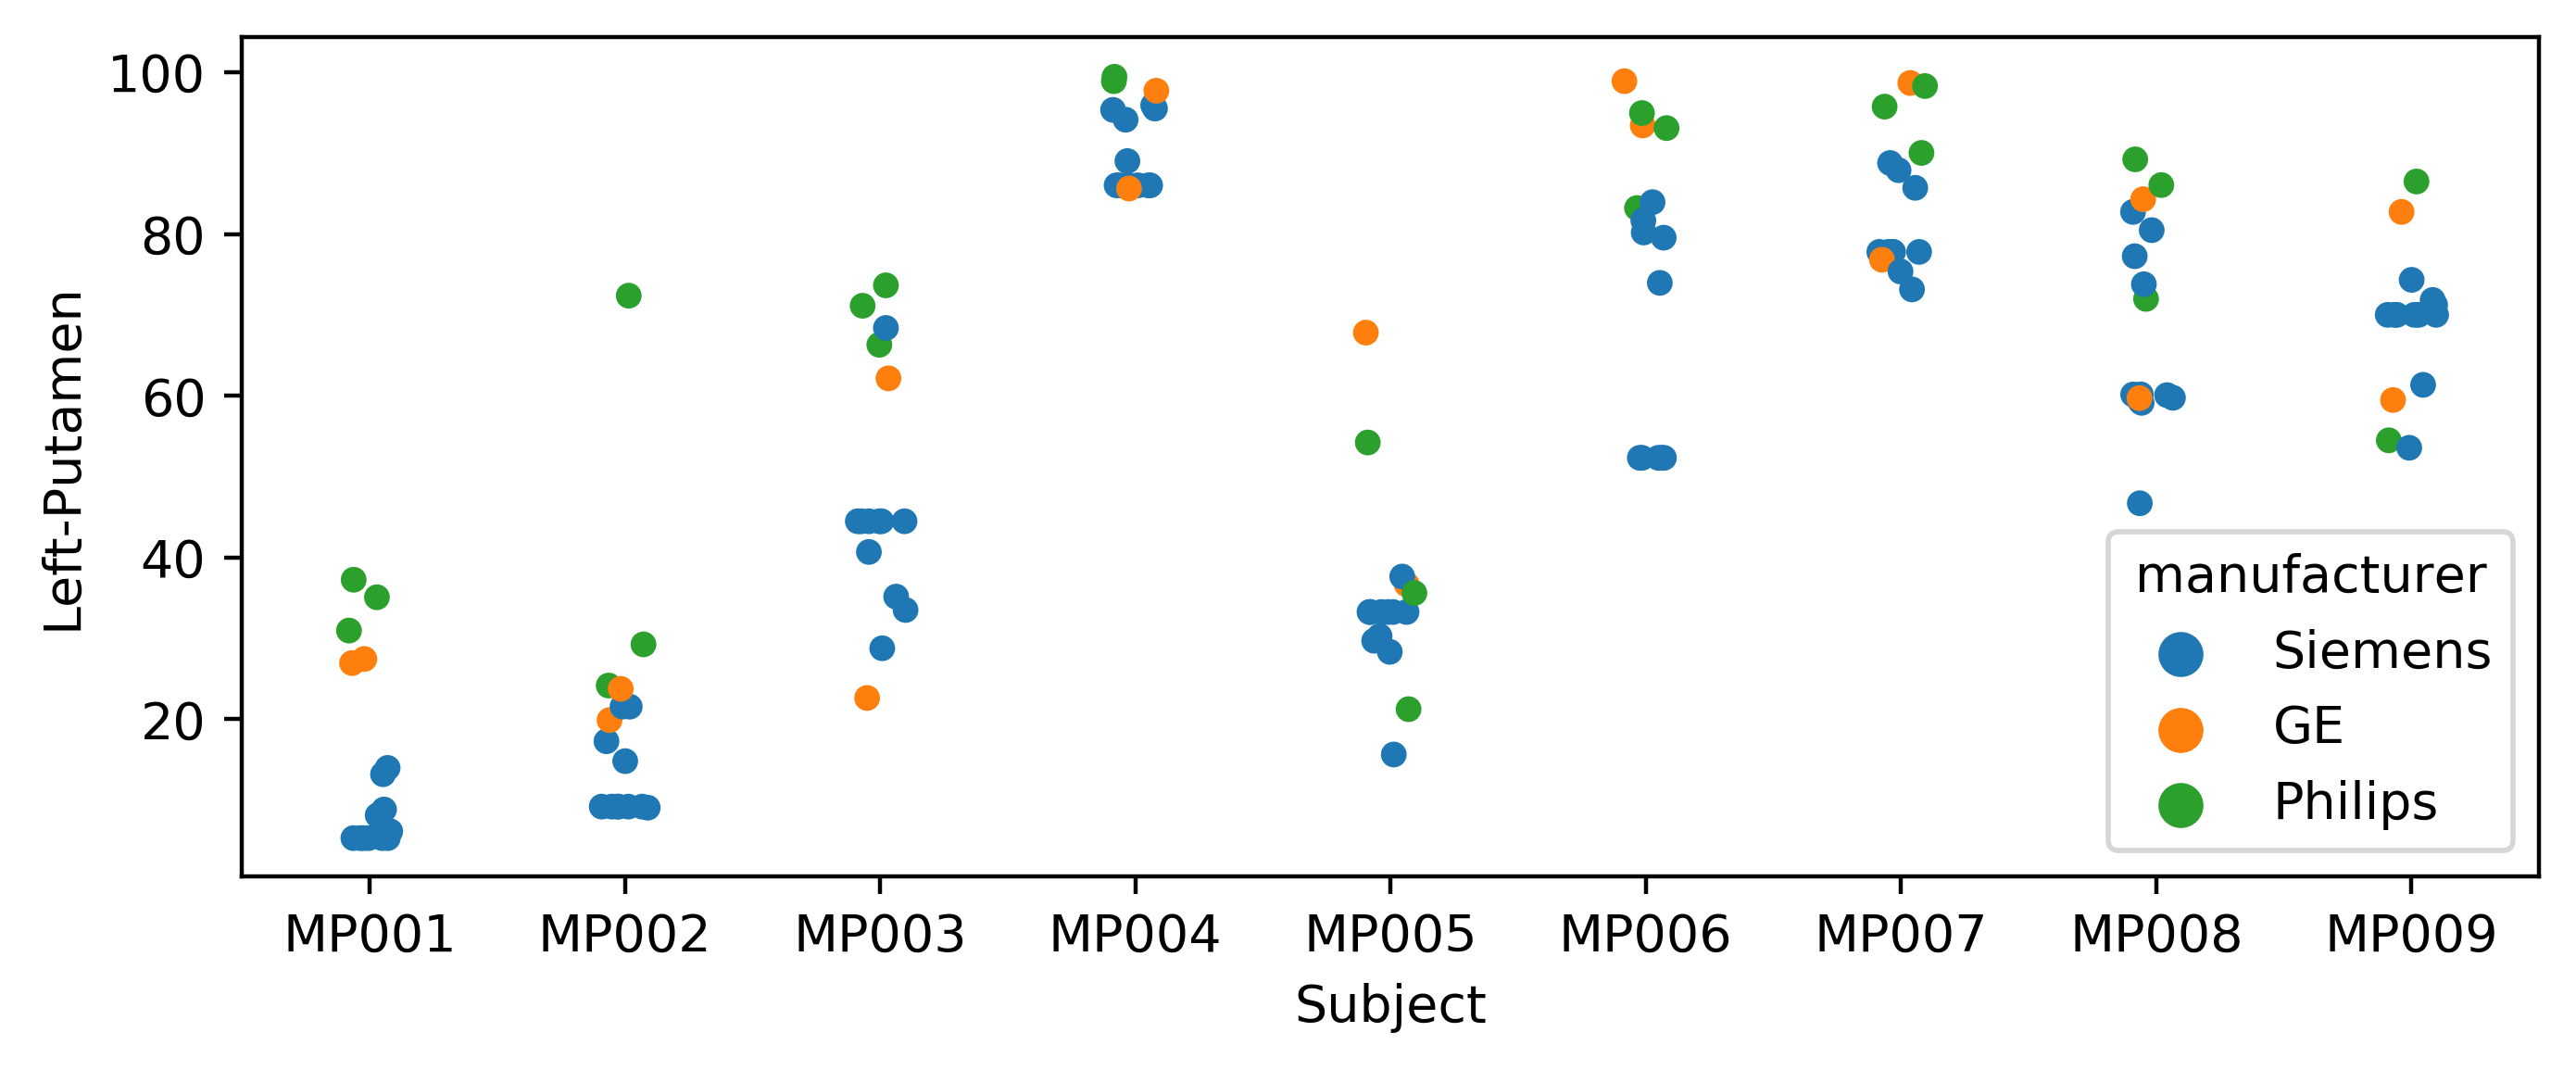

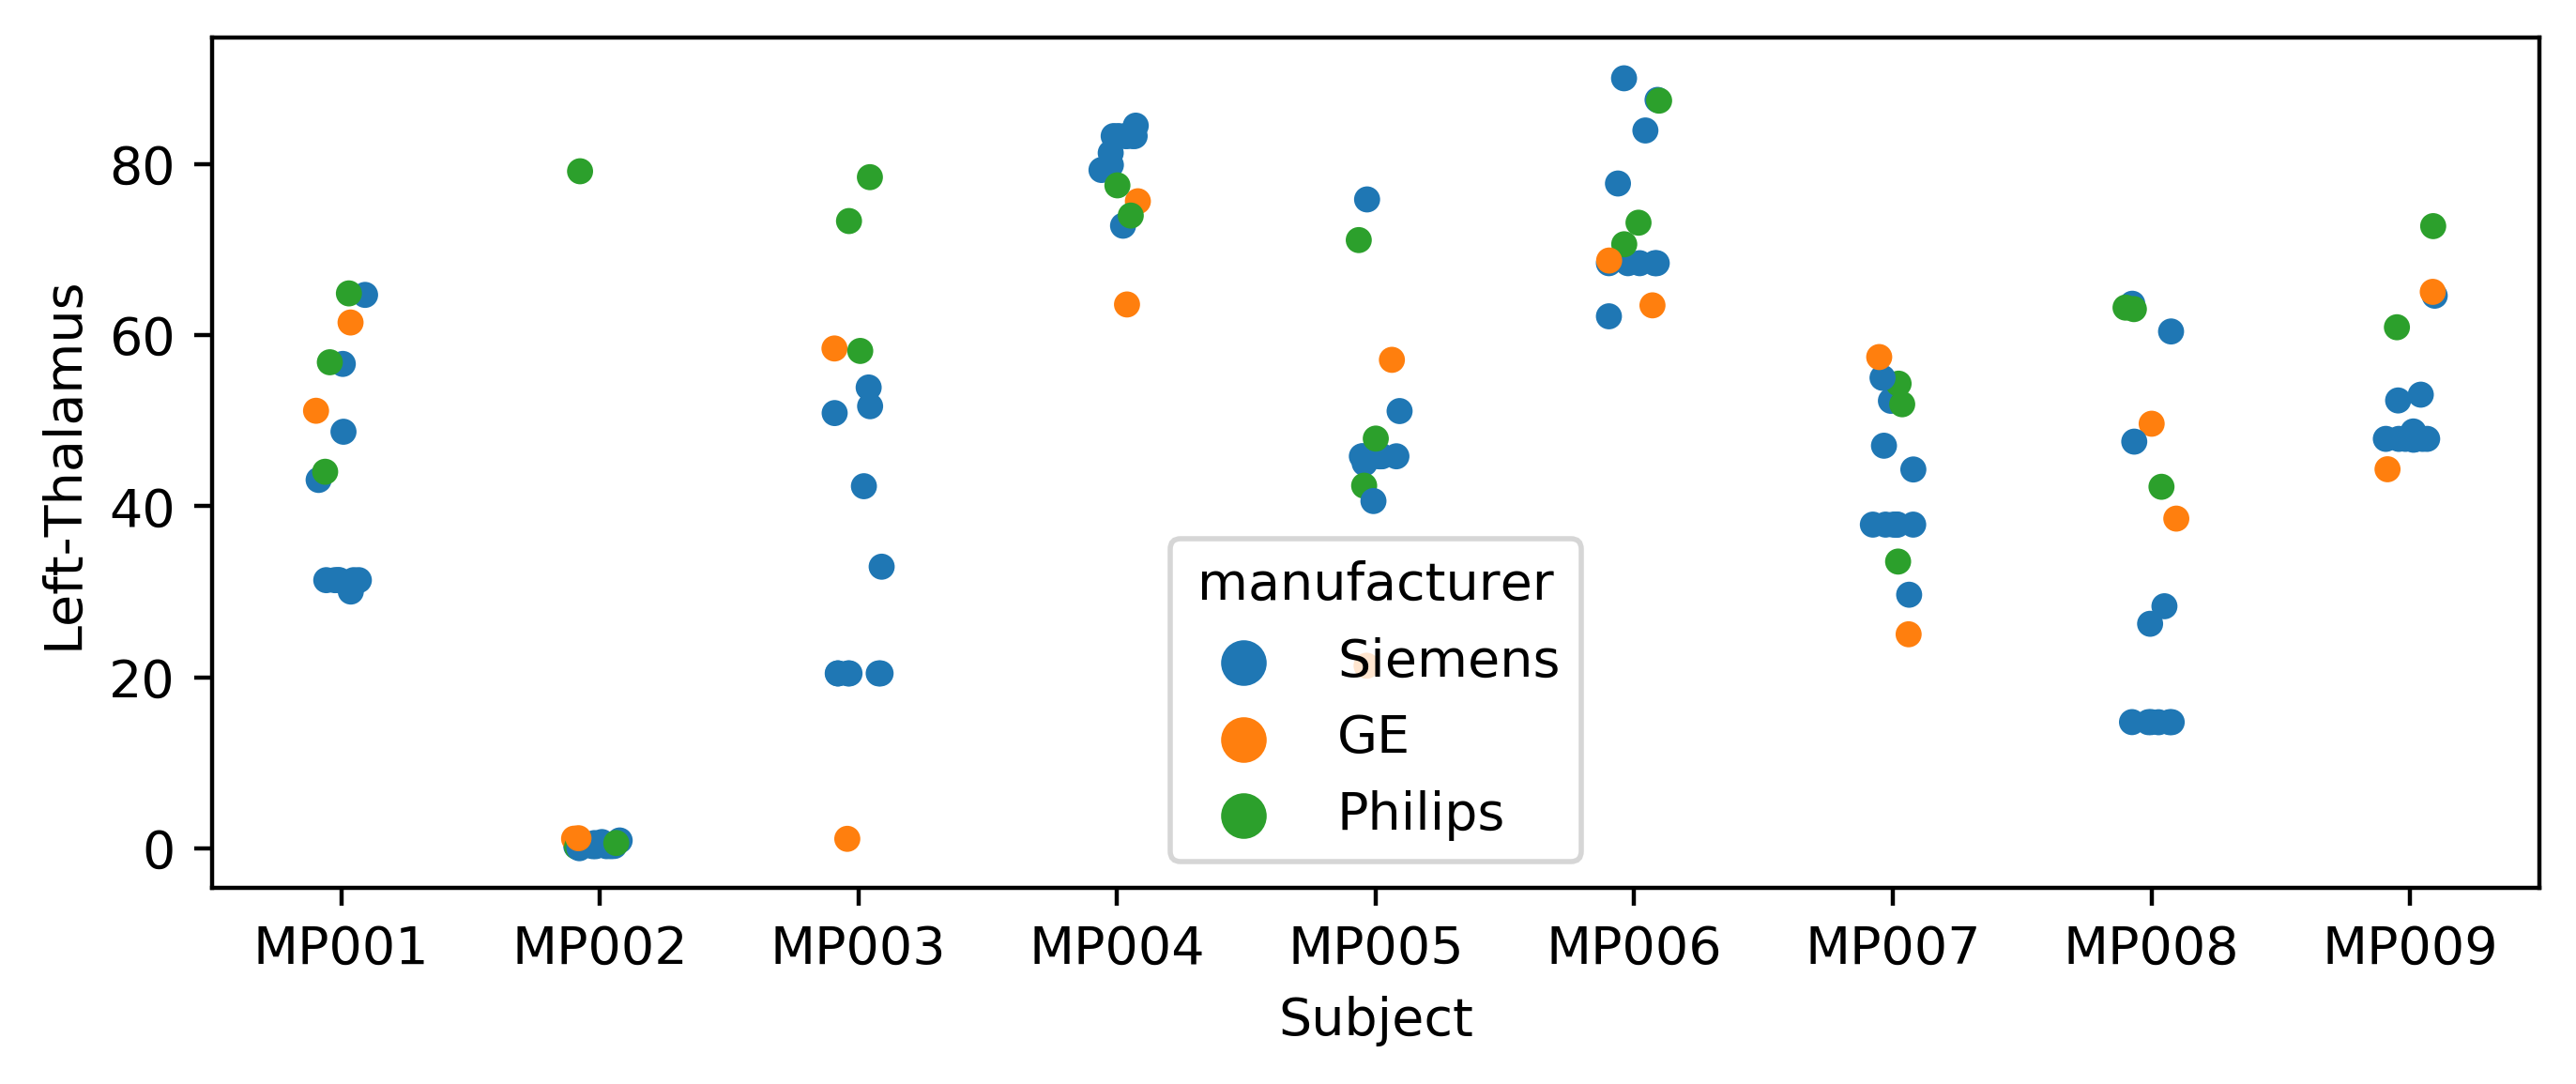

In [23]:
filestem = 'figs/decnef-normative--'
for struct in structs_of_interest:
    fig, ax = plt.subplots(dpi=400)
    fig.set_size_inches(8, 3)
    p = sns.stripplot(
        x='Subject',
        y=struct,
        hue='manufacturer',
        data=decnef_norm_df
    )
    plt.savefig(filestem+struct+".png")    

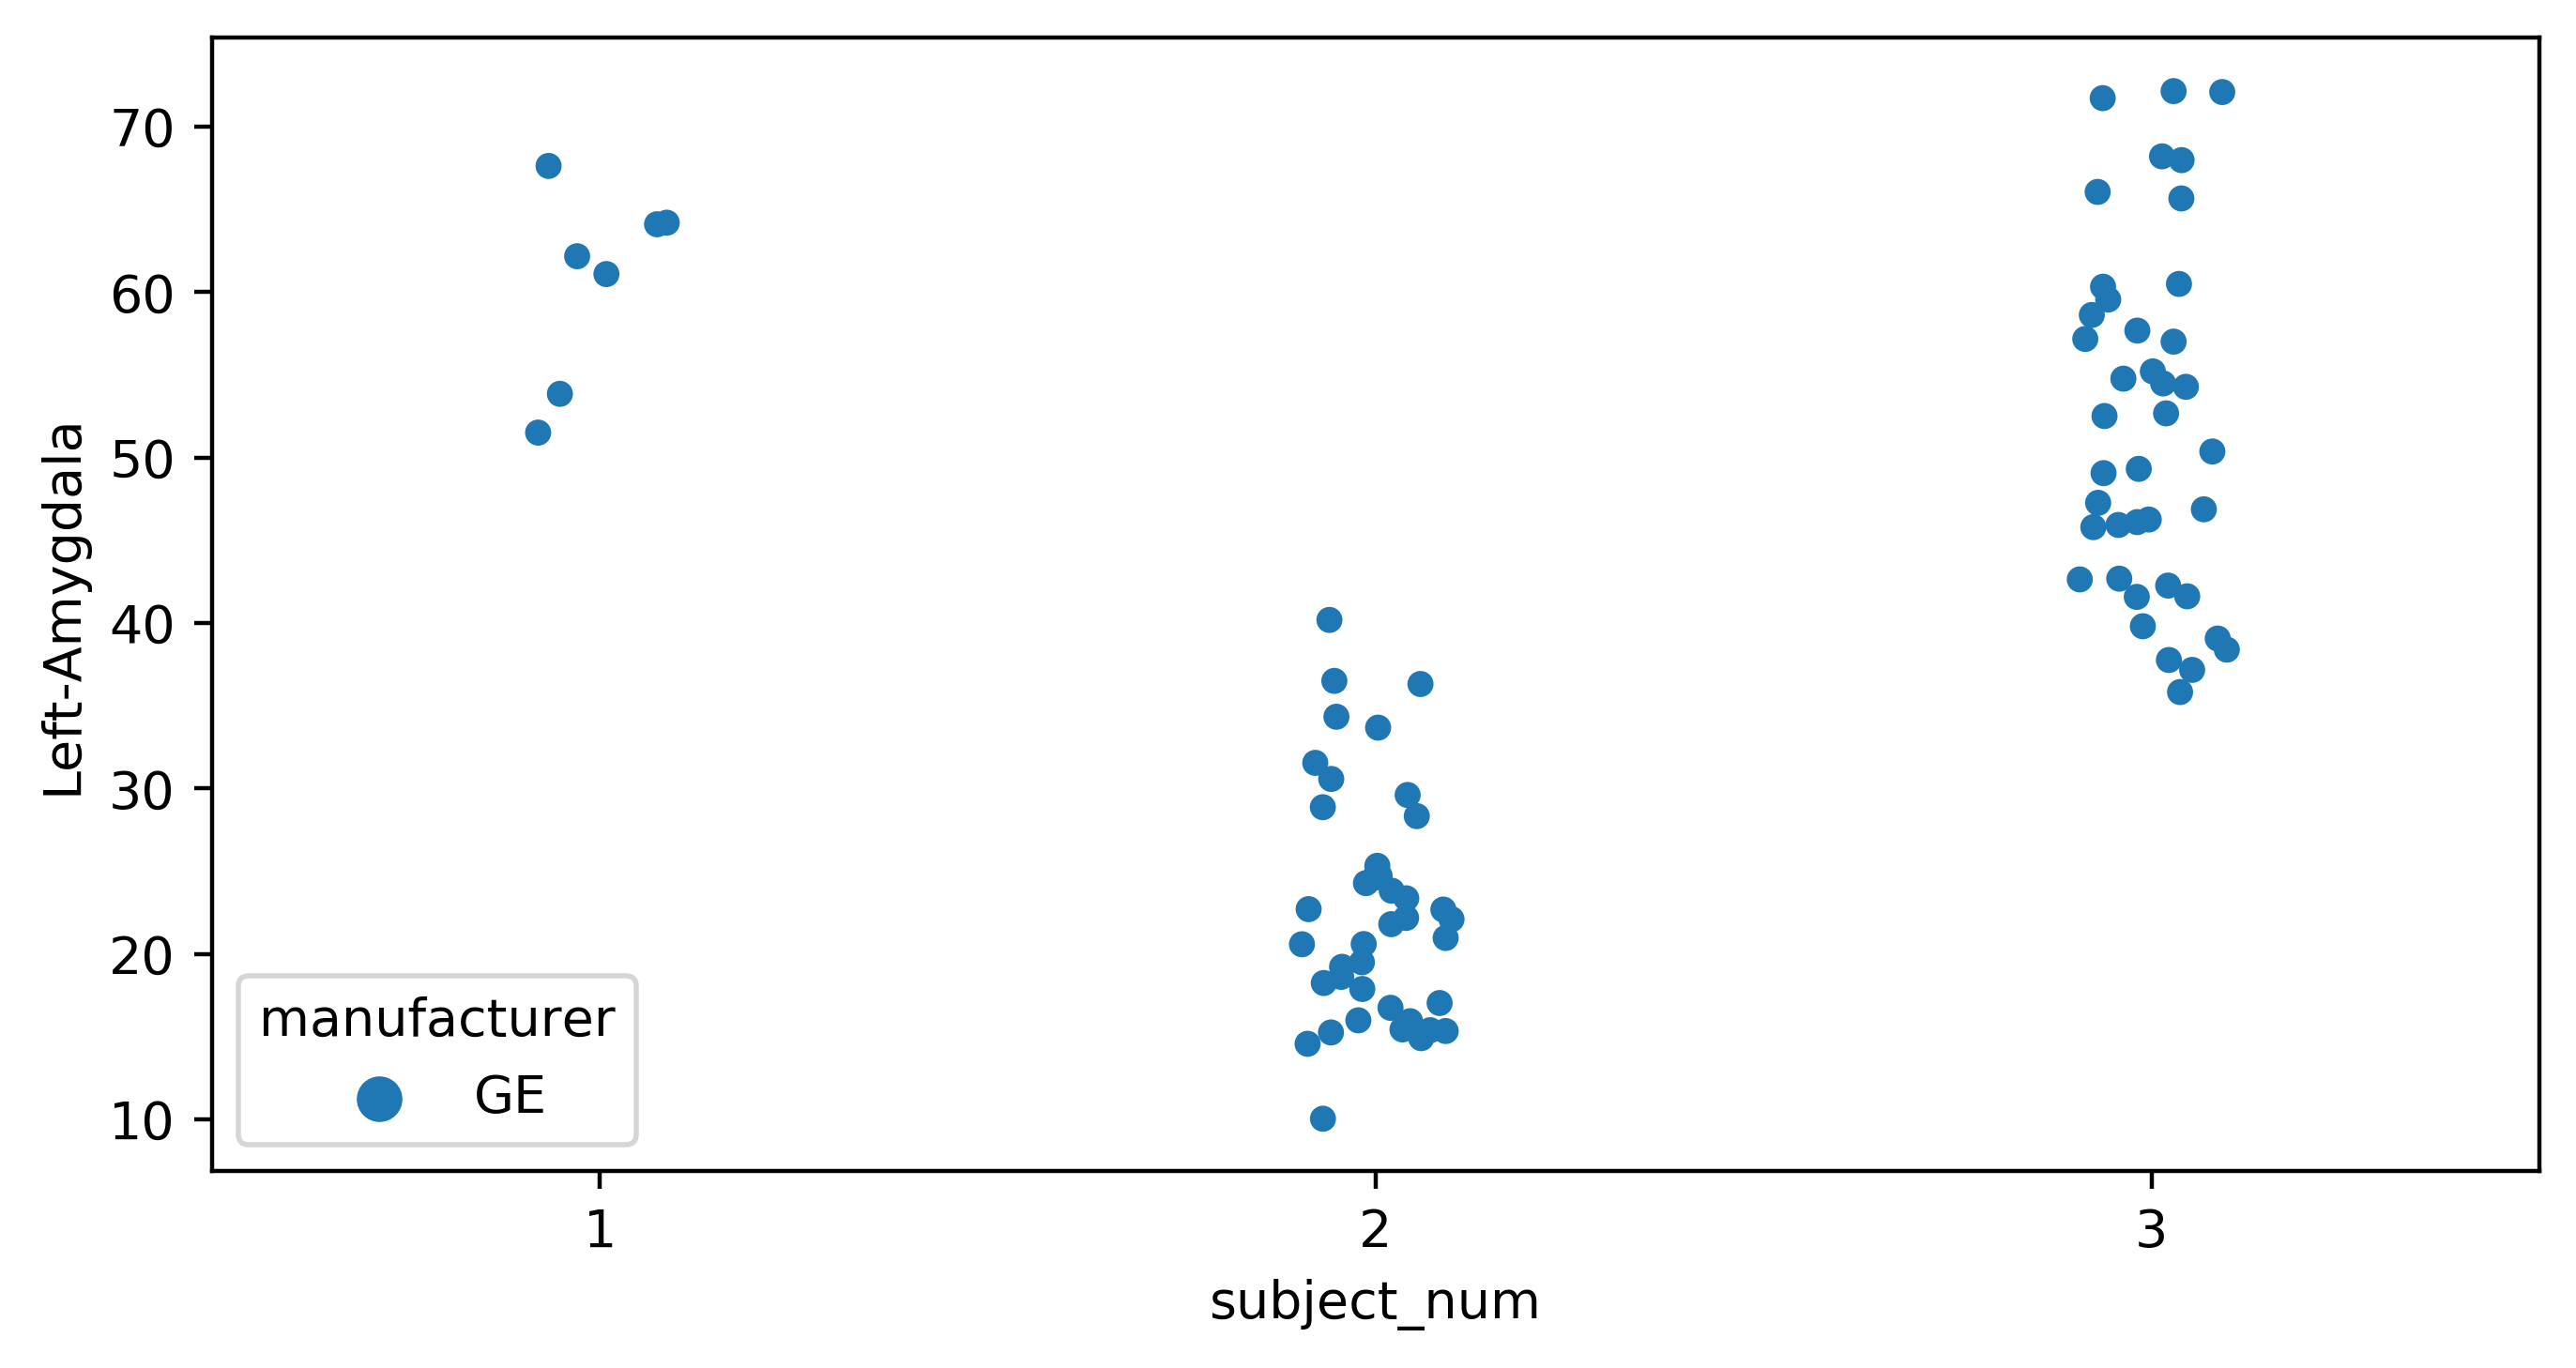

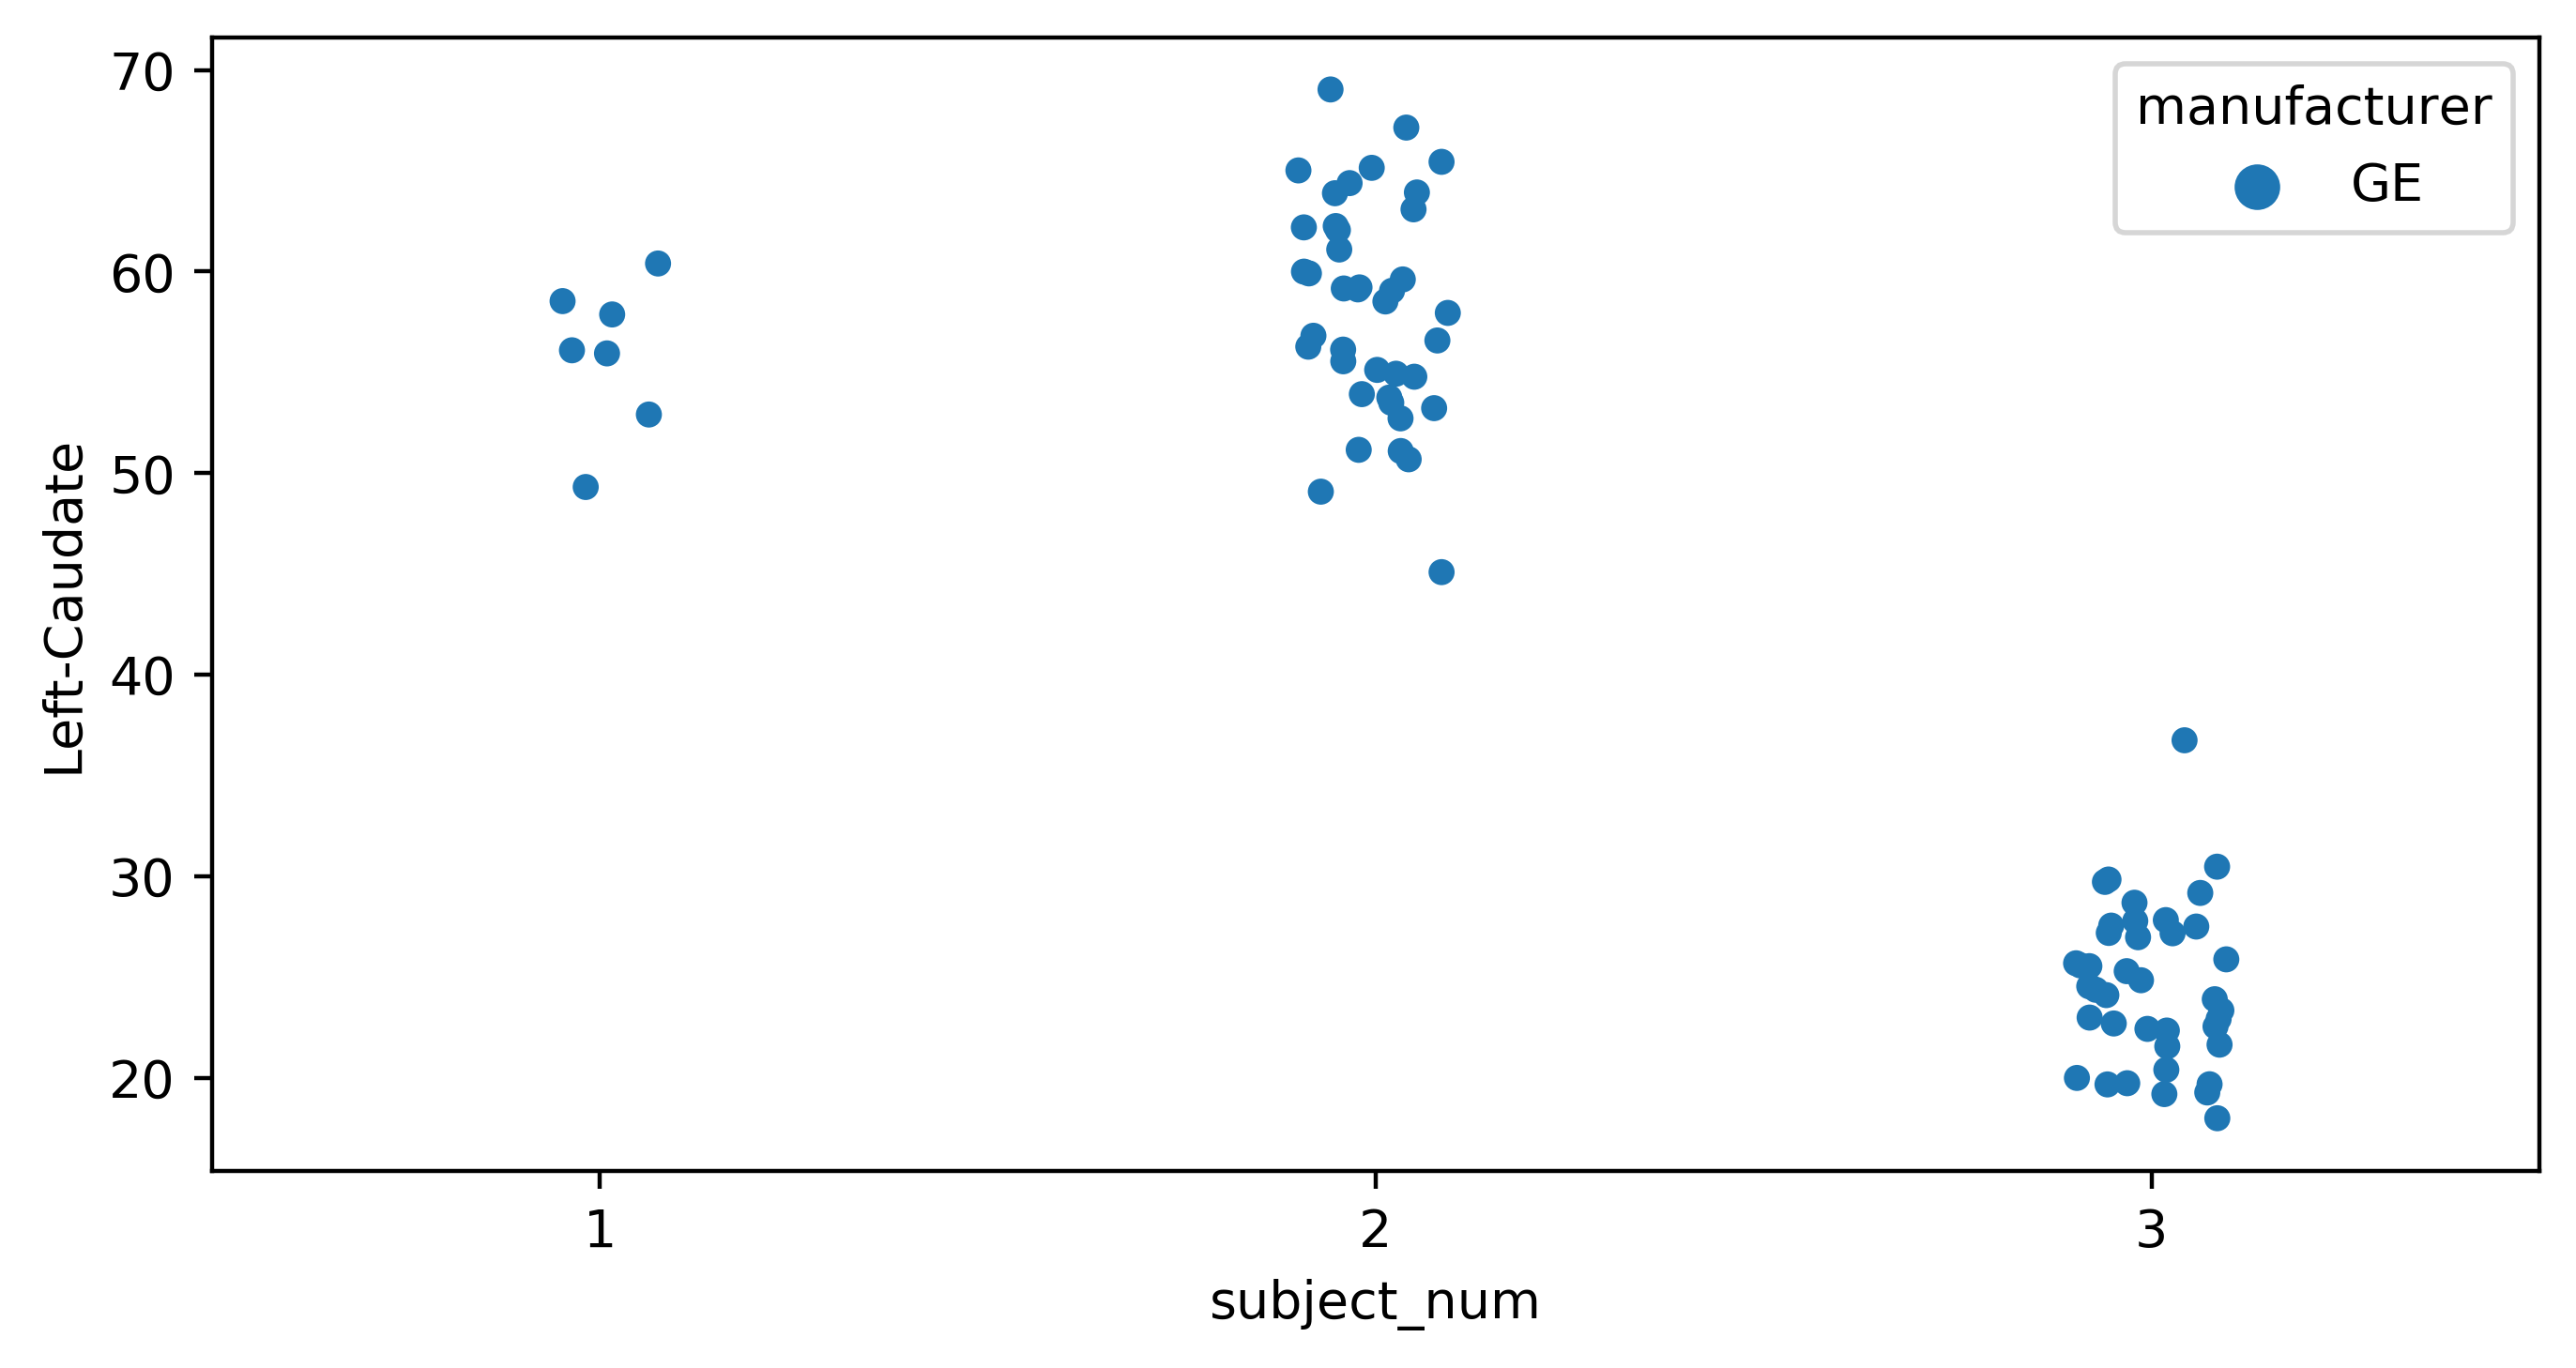

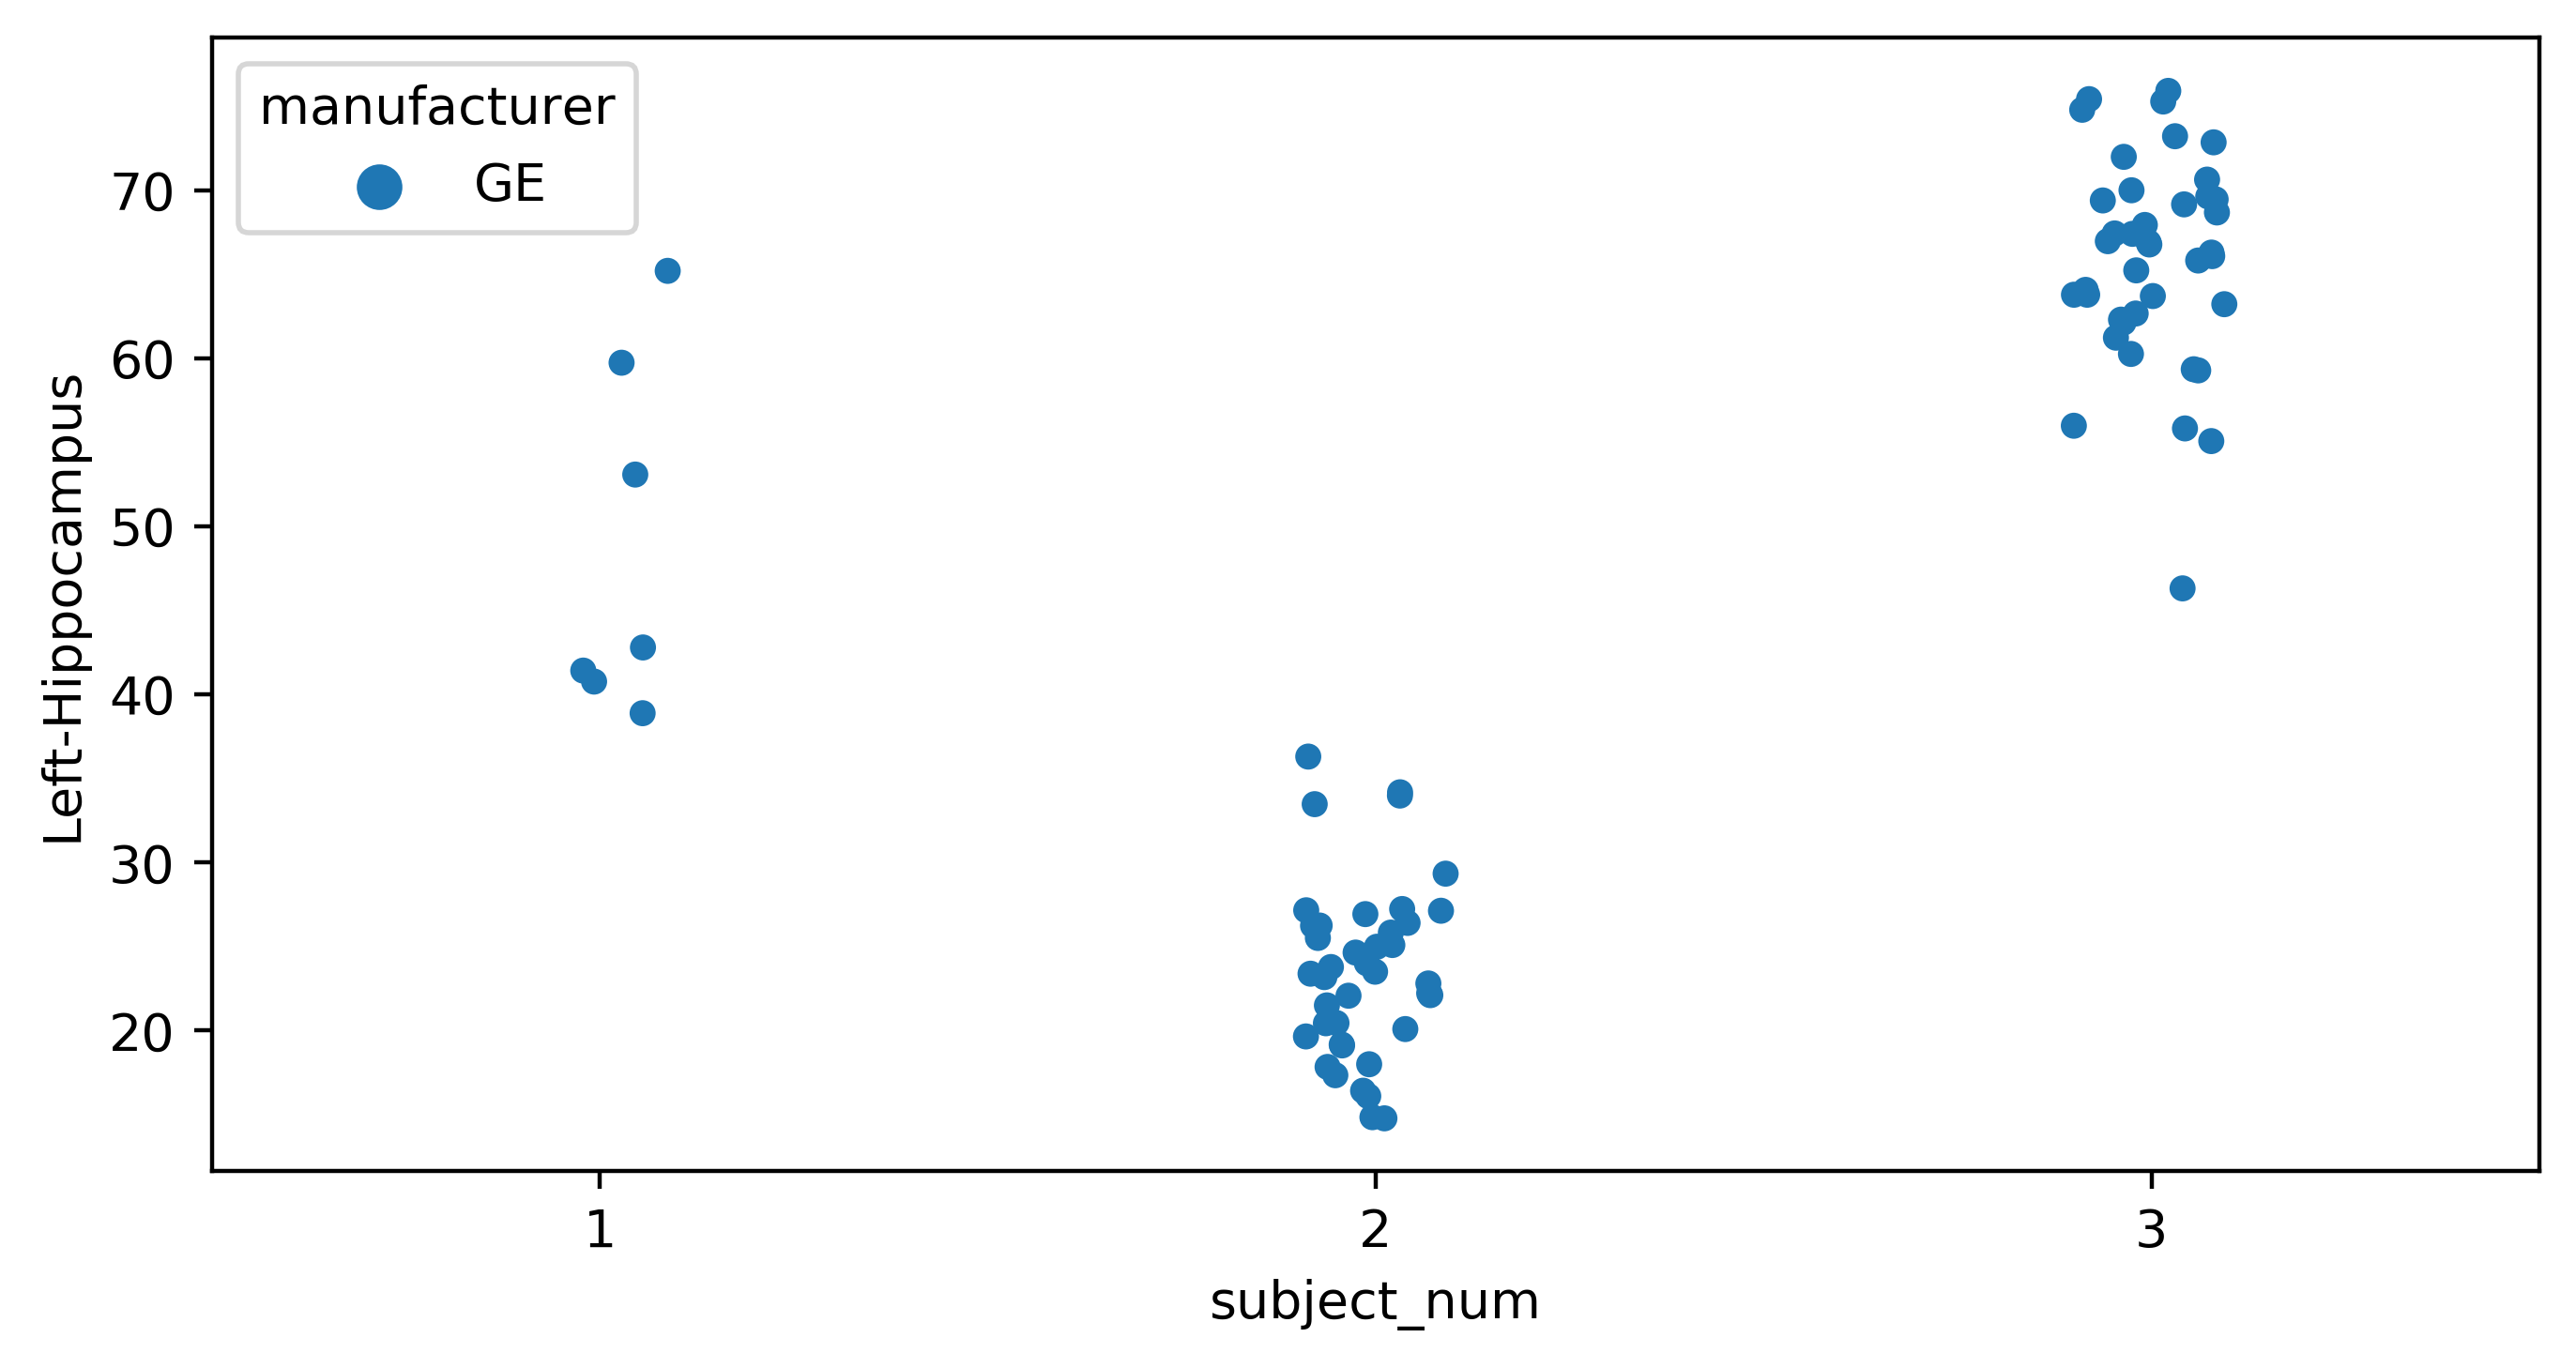

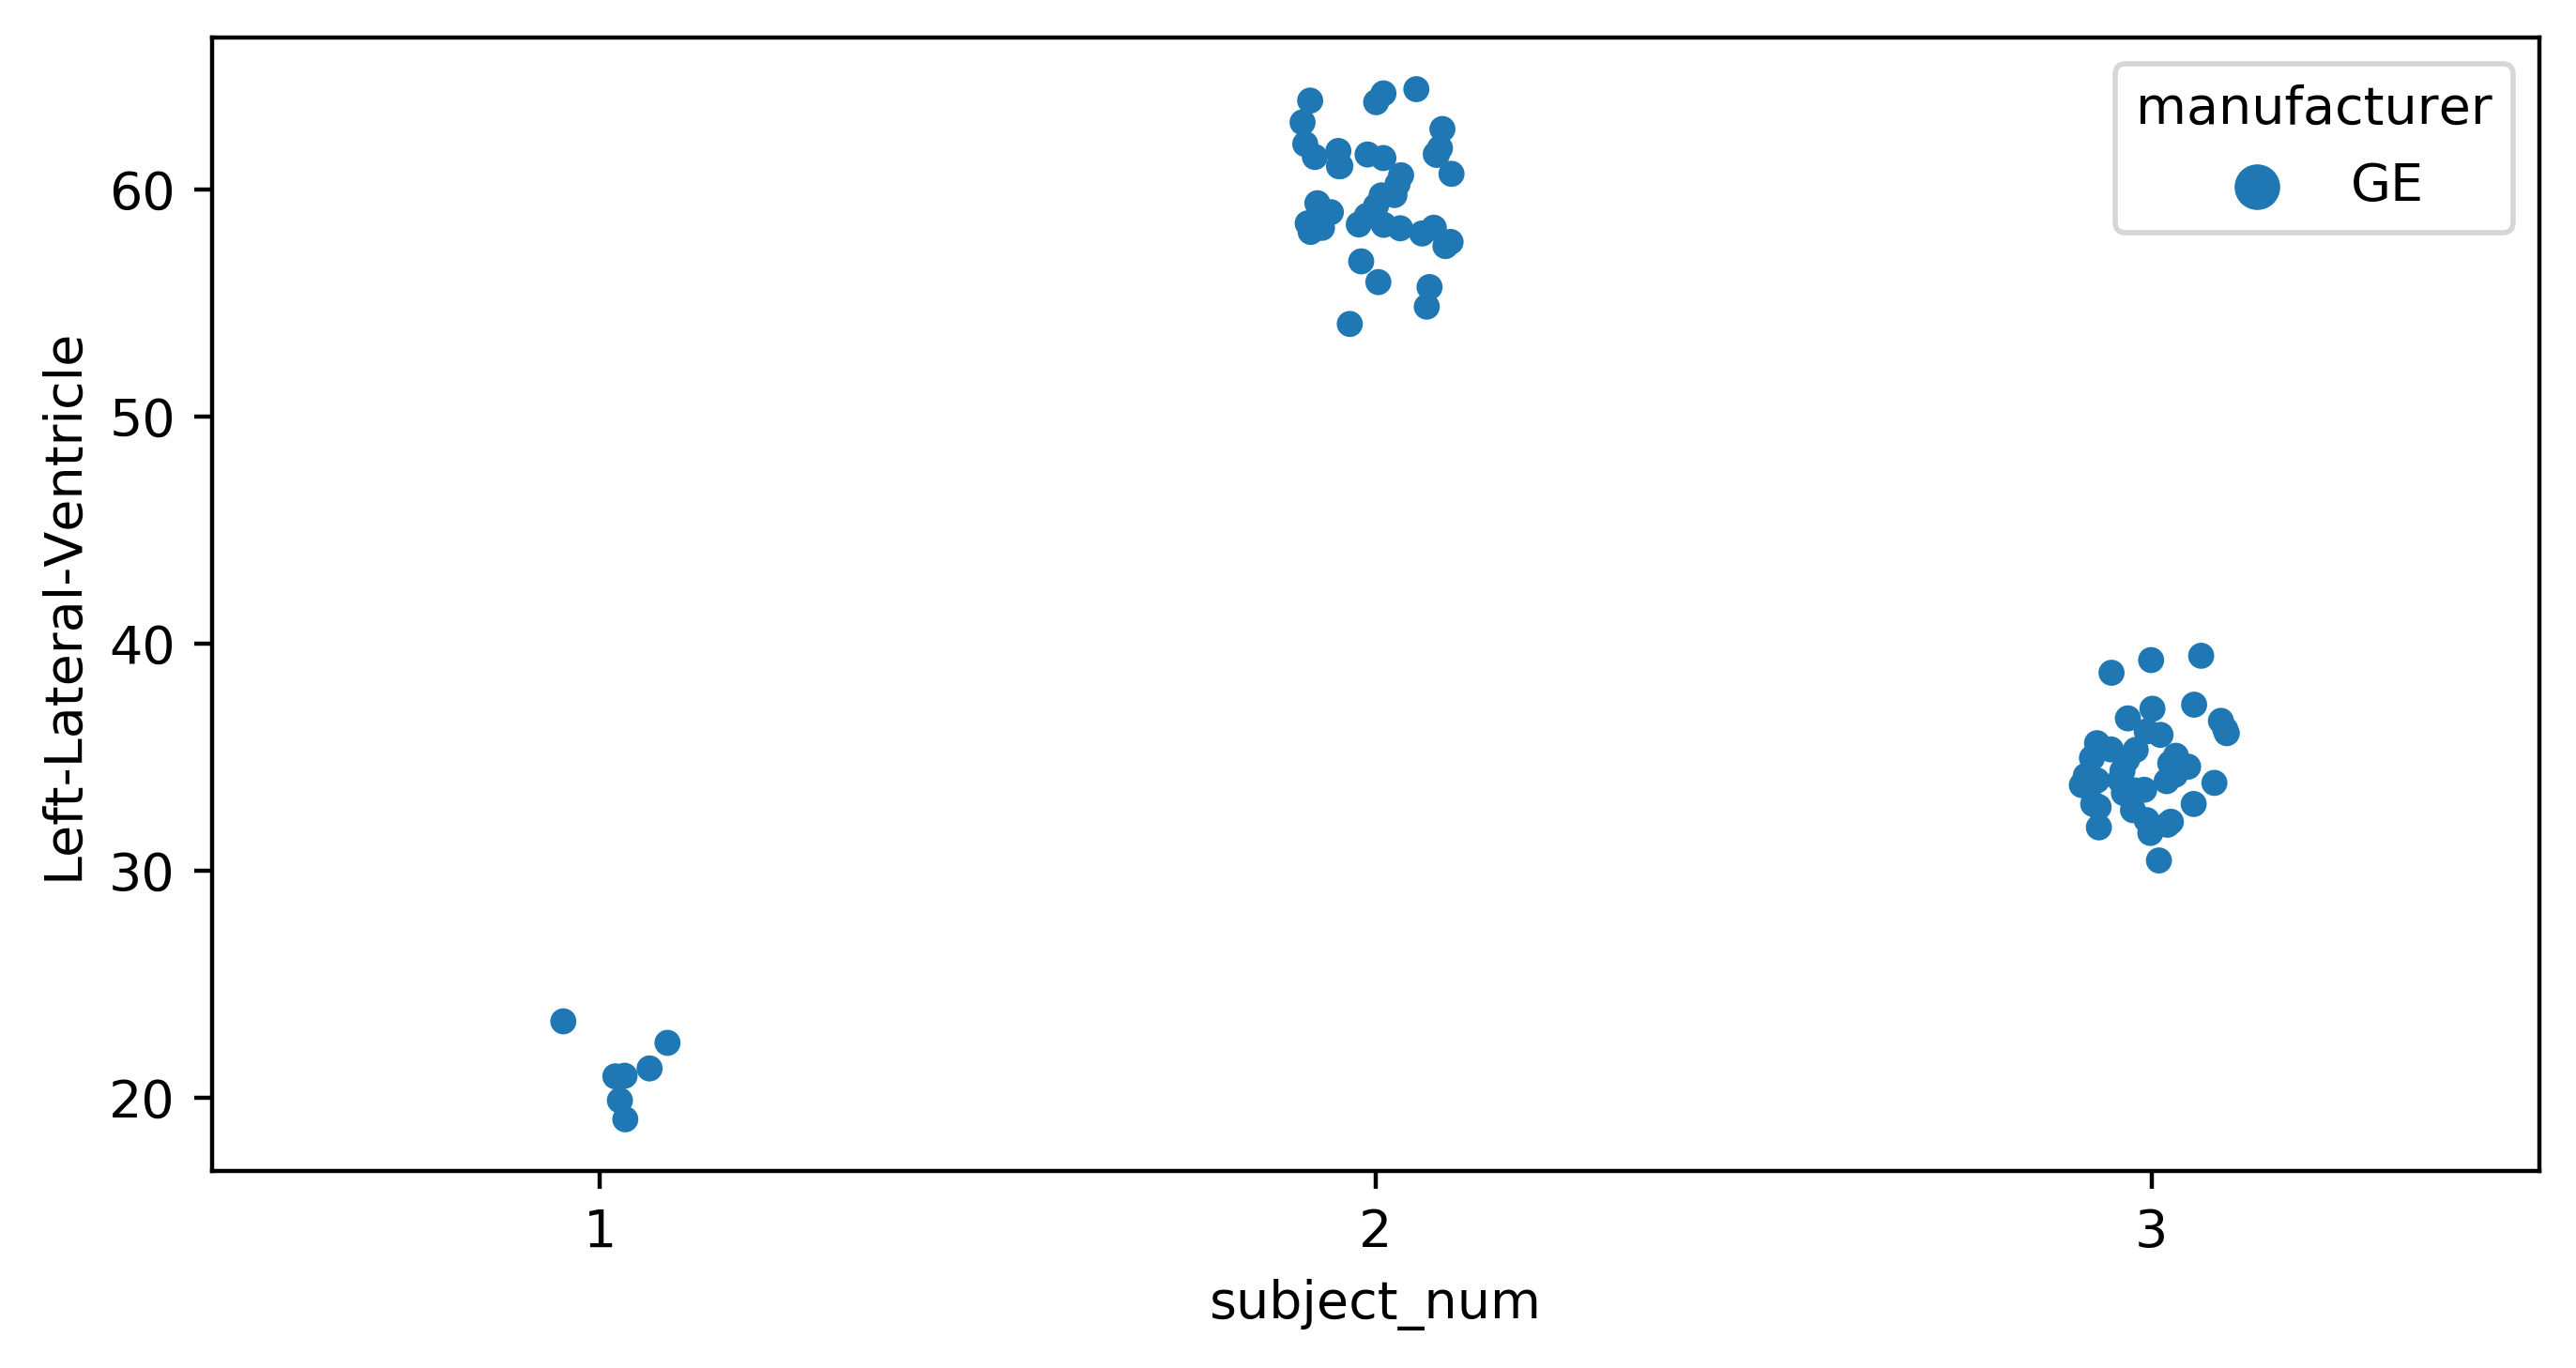

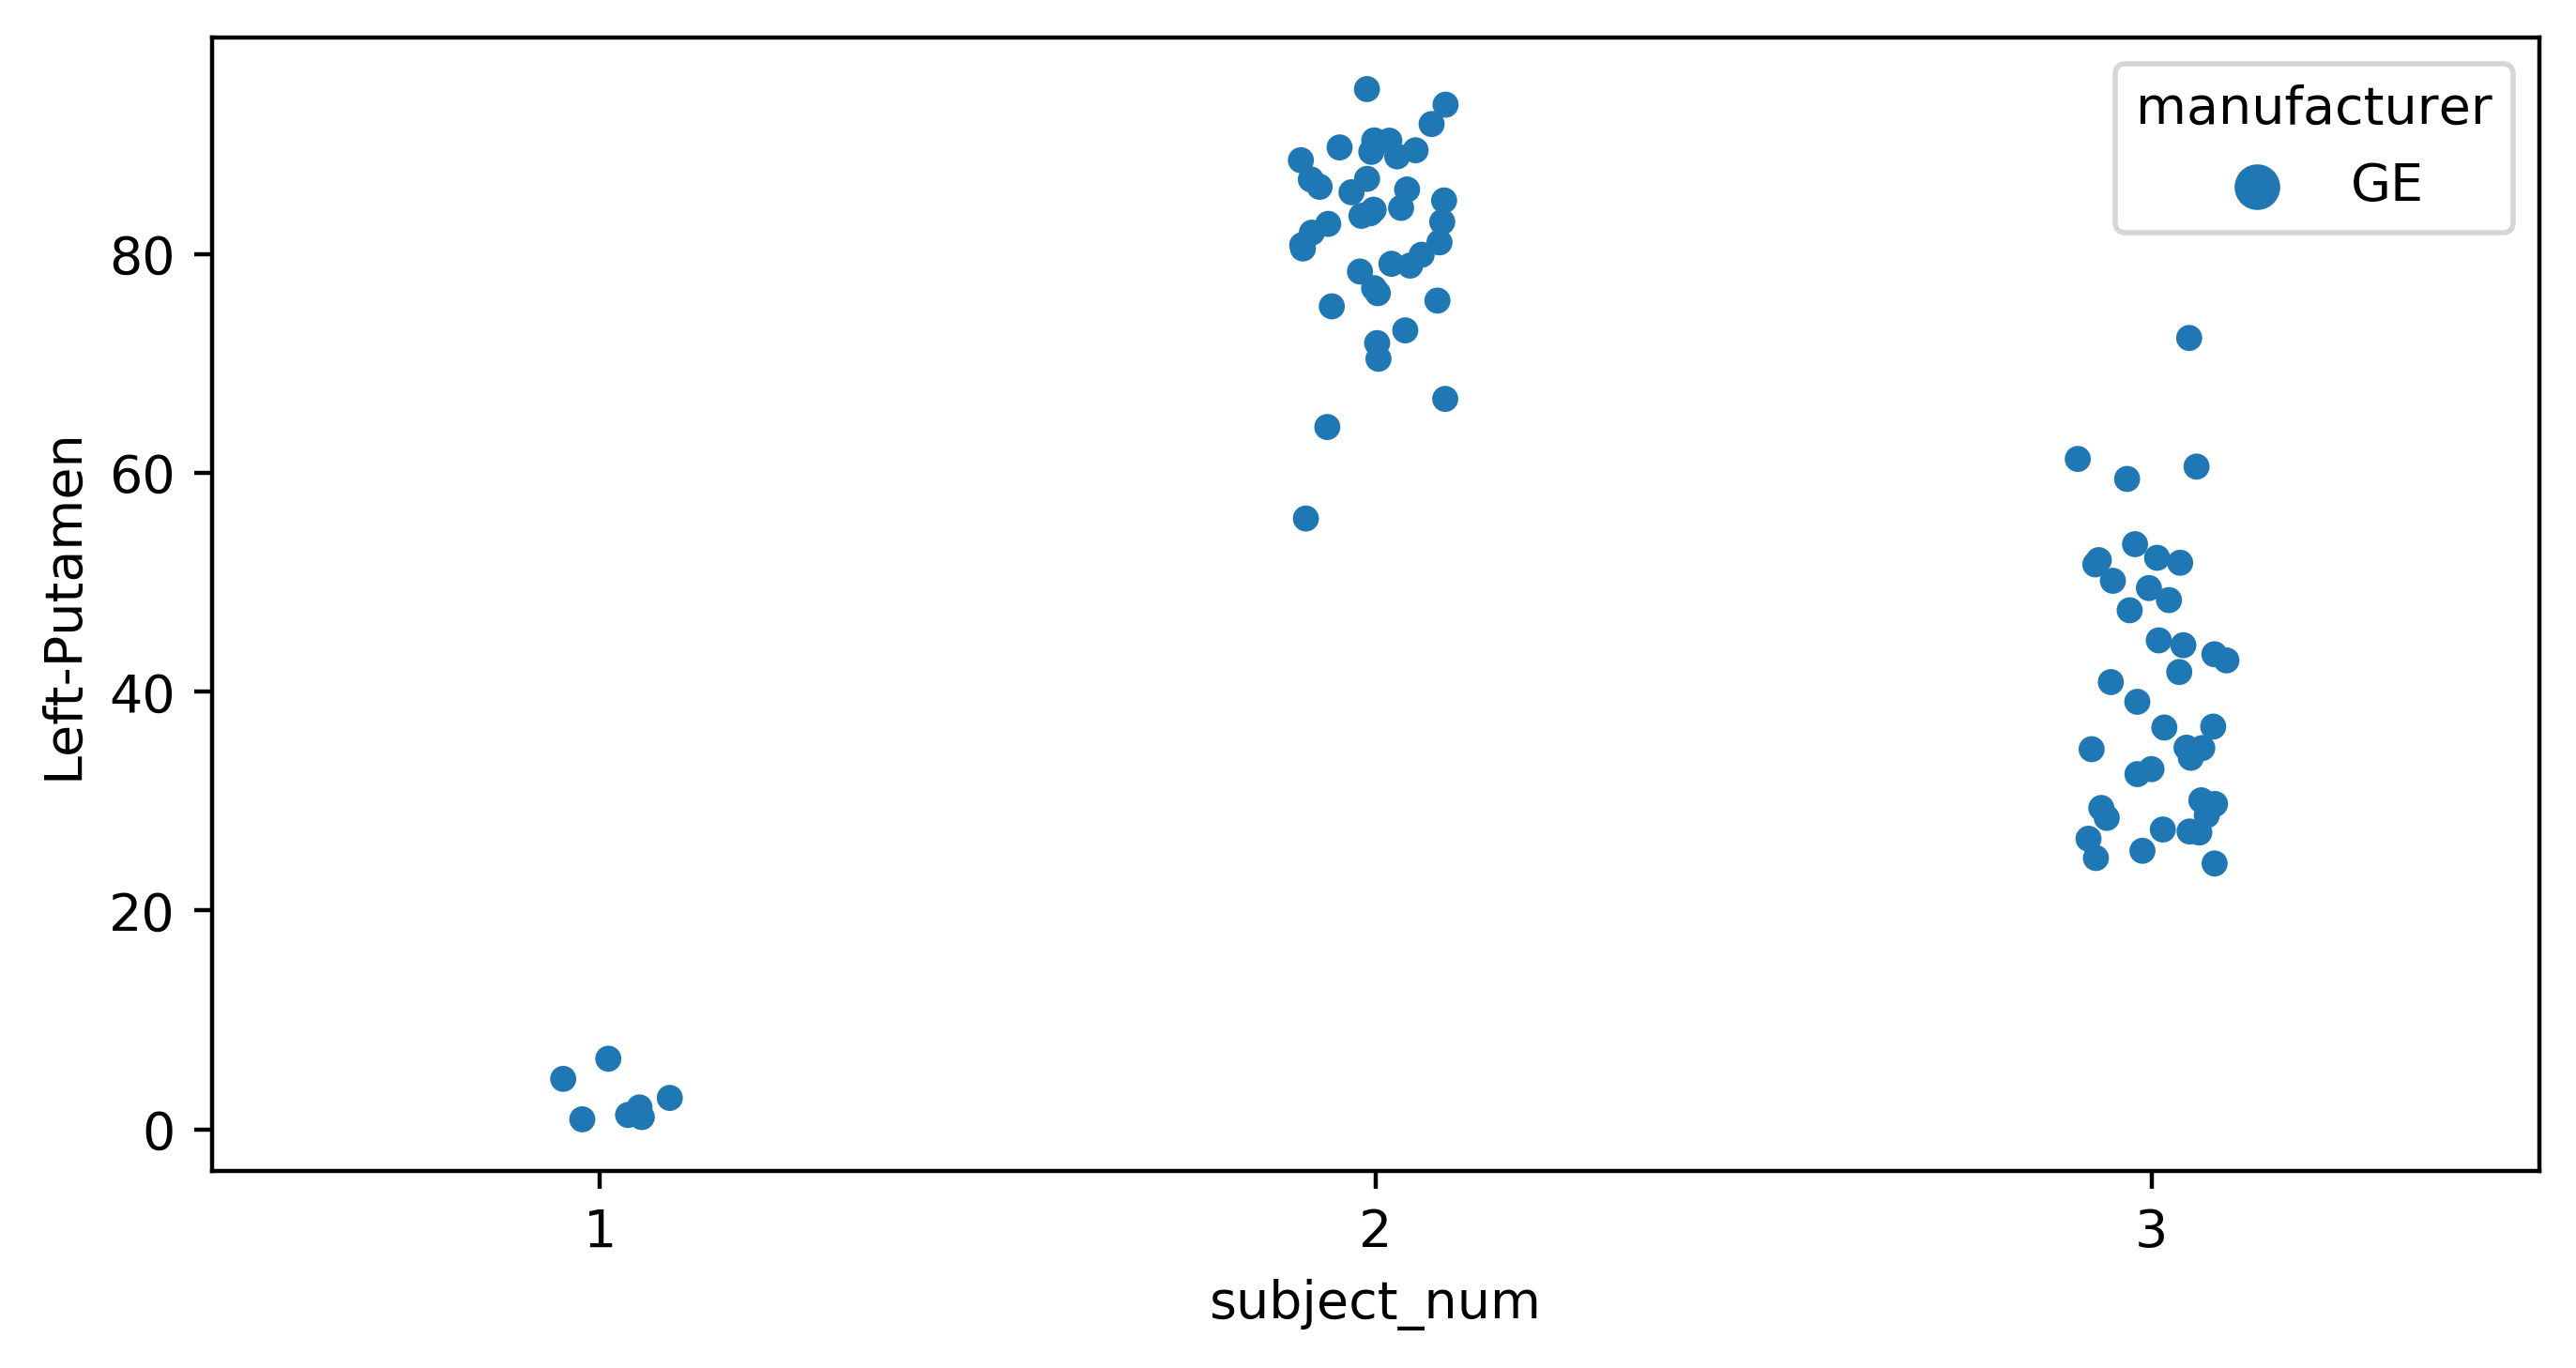

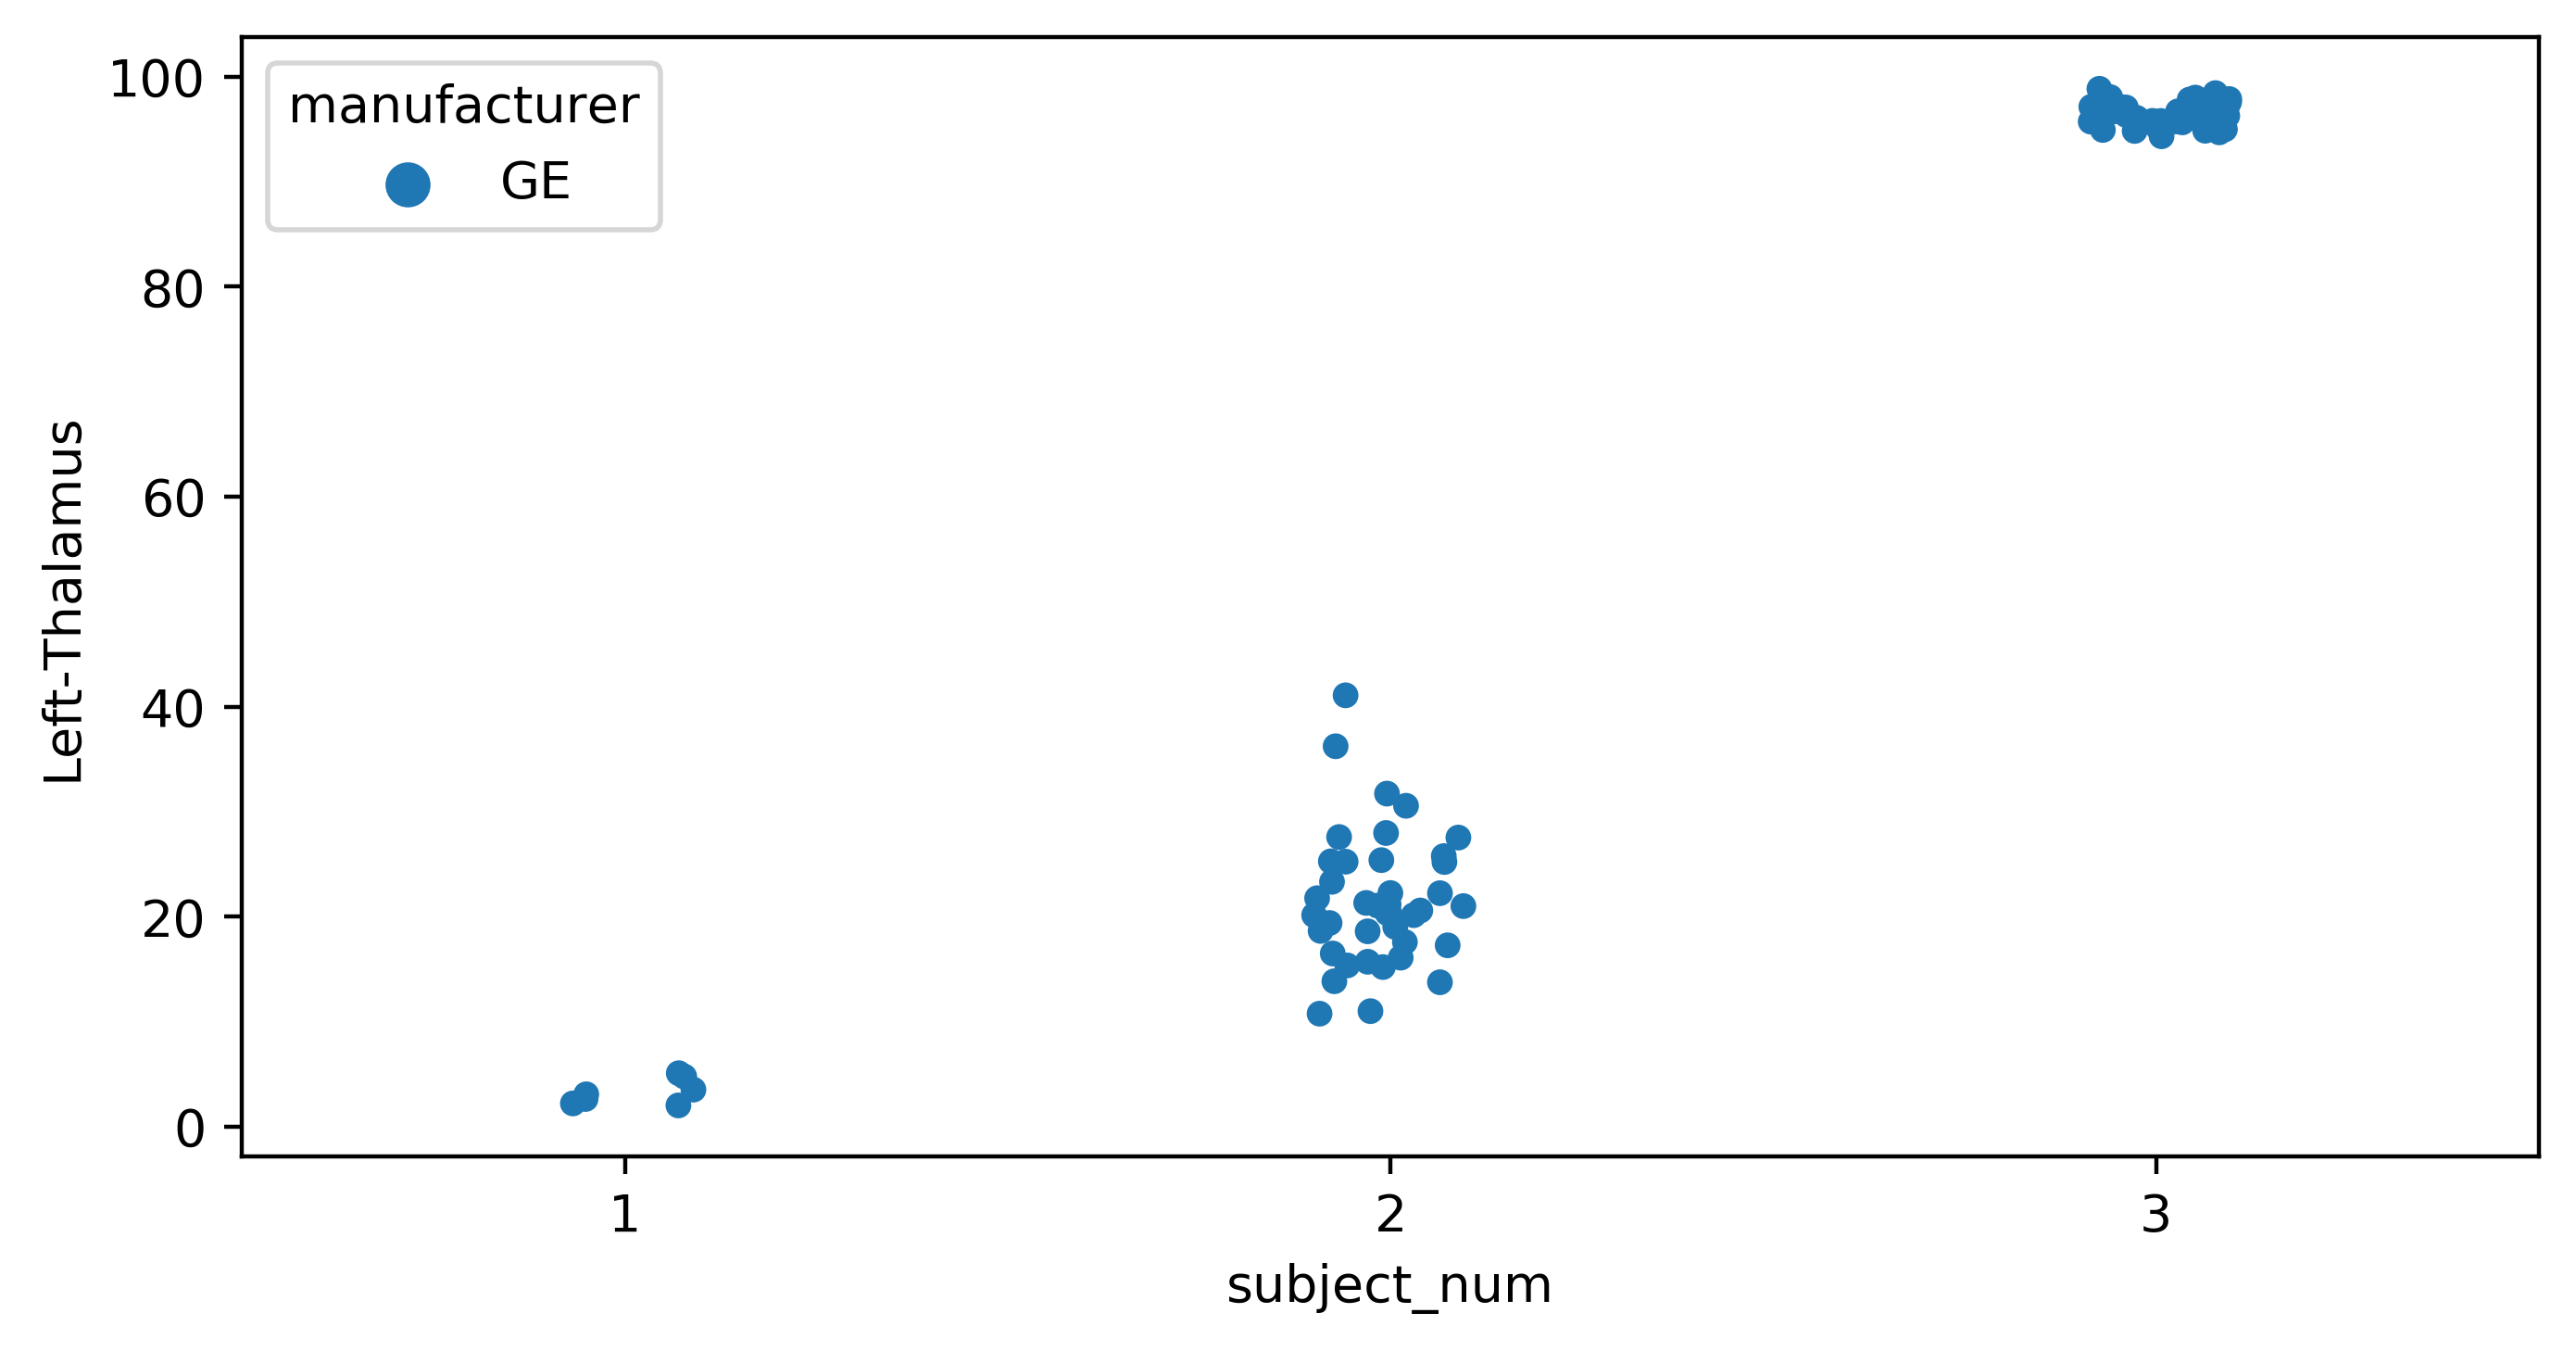

In [22]:
filestem = 'figs/maclaren-normative--'
for struct in structs_of_interest:
    fig, ax = plt.subplots(dpi=400)
    fig.set_size_inches(8, 4)
    p = sns.stripplot(
        x='subject_num',
        y=struct,
        hue='manufacturer',
        data=maclaren_norm_df
    )
    plt.savefig(filestem+struct+".png")
